In [4]:
# installs
# !pip install wordcloud

In [2]:
import pandas as pd
import pyspark.sql.functions as F
from datetime import datetime
from pyspark.sql.types import *
from wordcloud import WordCloud, STOPWORDS
import numpy as np
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

In [3]:
# dataviz
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

<hr />

# srag 2019

<hr />

In [3]:
srag_2019 = spark.read.csv('gs://ai-covid19-datalake/raw/srag/2019/srag_2019.csv', inferSchema=True, header=True, sep=';')

In [4]:
# 2019 has 25769809472 as max value
srag_2019 = srag_2019.withColumn('NU_NOTIFIC', F.monotonically_increasing_id())

In [5]:
srag_2019.select('NU_NOTIFIC').describe().show()
print('How many distincts: ', srag_2019.select('NU_NOTIFIC').distinct().count())

+-------+--------------------+
|summary|          NU_NOTIFIC|
+-------+--------------------+
|  count|               50152|
|   mean|1.045926964887567...|
| stddev| 8.583243509153521E9|
|    min|                   0|
|    max|         25769809472|
+-------+--------------------+

How many distincts:  50152


## about the columns

In [71]:
srag_2019.limit(5).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,NU_NOTIFIC
0,10/01/2019,2,06/01/2019,2,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620,UNIDADE DE PRONTO ATENDIMENTO LESTE,...,0,None,None,None,None,None,None,None,None,0
1,03/01/2019,1,01/01/2019,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HOSP MUN M BOI MIRIM,...,0,None,None,None,None,None,None,None,None,1
2,02/01/2019,1,31/12/2018,1,PE,1,1497,RECIFE,261160,IMIP,...,0,None,None,None,None,None,None,None,None,2
3,10/01/2019,2,07/01/2019,2,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950,HOSPITAL MUNICIPAL DR MARIO GATTI CAMPINAS,...,0,None,None,None,None,None,None,None,None,3
4,11/01/2019,2,06/01/2019,2,PE,4,1499,CARUARU,260410,SECRETARIA MUNICIPAL DE SAUDE DE CARUARU,...,0,None,None,None,None,None,None,None,None,4


In [6]:
# columns types according to srag dictionary
# date_type: 
date_type_columns = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_VGM', 'DT_RT_VGM', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 
                     'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_EVOLUCA', 'DT_DIGITA']


# location categorical cols:
location_cat_cols = ['SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'SG_UF', 'ID_MN_RESI', 'CO_MUN_RES',
                     'CS_ZONA', 'ID_PAIS', 'CO_PAIS', 'HISTO_VGM', 'PAIS_VGM', 'CO_PS_VGM', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE',
                     'ID_MN_INTE', 'CO_MU_INTE']

# semi identifiers 
semi_id_cat_cols = ['NU_NOTIFIC', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'PAC_COCBO', 'PAC_DSCBO', 'AVE_SUINO']


# symptoms
symptoms_cat_cols = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN']


# risk factor 
risk_factor_cat_cols = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 
                        'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI']
                                   


# case descriptors
case_desc_cat_cols = ['SURTO_SG', 'NOSOCOMIAL', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 
                      'RAIOX_RES', 'AMOSTRA', 'TP_AMOSTRA', 'IF_RESUL', 'POS_IF_FLU', 'TP_FLU_IF', 'POS_IF_OUT', 'LAB_IF', 'CO_LAB_IF',
                      'PCR_RESUL', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'PCR_FLUBLI', 'POS_PCROUT', 'LAB_PCR', 'CO_LAB_PCR',
                      'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO']


# varchar vars (could be id or numerical)
varchar_cols = ['NU_NOTIFIC', 'SEM_PRI', 'NU_IDADE_N', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC', 'OUT_ANTIV', 'RAIOX_OUT', 'OUT_AMOST', 'REQUI_GAL', 'DS_IF_OUT',
               'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'OBSERVA']




# ver 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC'
                                
                                
# Pontos de atencao: 
# Distancia entre primeiros sintomas e teste ('DT_PCR')
# Distancia entre primeiros sintomas e evolucao ('DT_EVOLUCA', 'DT_ENCERRA')

In [7]:
srag_2019.printSchema()

root
 |-- DT_NOTIFIC: string (nullable = true)
 |-- SEM_NOT: string (nullable = true)
 |-- DT_SIN_PRI: string (nullable = true)
 |-- SEM_PRI: string (nullable = true)
 |-- SG_UF_NOT: string (nullable = true)
 |-- ID_REGIONA: string (nullable = true)
 |-- CO_REGIONA: string (nullable = true)
 |-- ID_MUNICIP: string (nullable = true)
 |-- CO_MUN_NOT: string (nullable = true)
 |-- ID_UNIDADE: string (nullable = true)
 |-- CO_UNI_NOT: string (nullable = true)
 |-- CS_SEXO: string (nullable = true)
 |-- DT_NASC: string (nullable = true)
 |-- NU_IDADE_N: integer (nullable = true)
 |-- TP_IDADE: integer (nullable = true)
 |-- COD_IDADE: integer (nullable = true)
 |-- CS_GESTANT: integer (nullable = true)
 |-- CS_RACA: integer (nullable = true)
 |-- CS_ETINIA: string (nullable = true)
 |-- CS_ESCOL_N: integer (nullable = true)
 |-- ID_PAIS: string (nullable = true)
 |-- CO_PAIS: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CO_RG_RESI: integer (nullable = true)
 |-- ID_MN

## Formatting data type variables

In [8]:
# some values on var 'DT_NOTIFIC' has strange values, such as:  "UTI 17/02/2019 04/03/2019" or "DATA INTERNACAO 28/4/19.  20/08/2019- PERMANECE INTERNADA"

# Converting to proper data type on pyspark
before_count = srag_2019.count()
print('Number of lines before date formatting: ', before_count)
for col in date_type_columns:
    srag_2019 = srag_2019.withColumn(col, F.to_date(F.col(col), 'dd/MM/yyyy'))
    if col == 'DT_NOTIFIC':
        srag_2019 = srag_2019.filter((F.year(col) != 18) & (F.year(col) != 19) & (F.year(col) != 20))

after_count = srag_2019.count()
print('Number of lines before date formatting: ', srag_2019.count())
total_count = before_count - after_count
print('A total of lines deleted: ', total_count)

Number of lines before date formatting:  50152
Number of lines before date formatting:  48554
A total of lines deleted:  1598


In [9]:
# Creating 'age' variable from the difference between date of birth and notification event
srag_2019 = srag_2019.withColumn("AGE_AT_NOTIF", F.datediff(F.col('DT_SIN_PRI'), F.col('DT_NASC'))/365.25)\
            .withColumn('AGE_AT_NOTIF', F.floor(F.col('AGE_AT_NOTIF')))

### some descriptions

<AxesSubplot:>

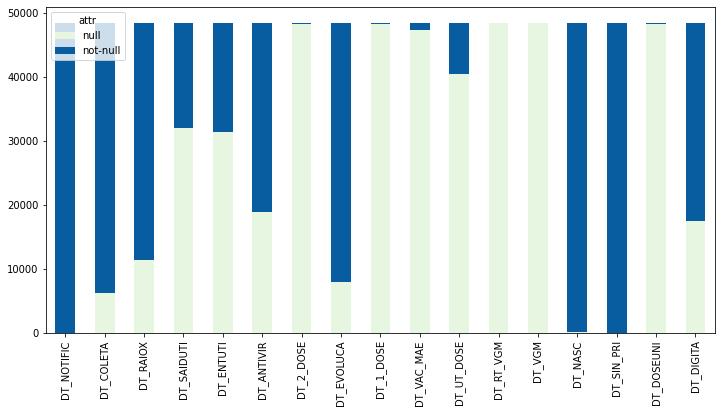

In [10]:
# quantifying nulls
pd_nulls_date_type_cols = srag_2019.select(date_type_columns)

# tagging nulls and not nulls values
for col in date_type_columns:
    pd_nulls_date_type_cols = pd_nulls_date_type_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_dates = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in date_type_columns:
    to_be_joined = pd_nulls_date_type_cols.select(col).groupby(col).count()
    null_dates = null_dates.join(to_be_joined, null_dates['attr'] == to_be_joined[col], 'left')
    null_dates = null_dates.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_dates = null_dates.withColumnRenamed('count', col)

null_dates = null_dates.toPandas()

# Plotting

null_dates.set_index('attr')\
  .reindex(null_dates.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:xlabel='AGE_AT_NOTIF', ylabel='Count'>

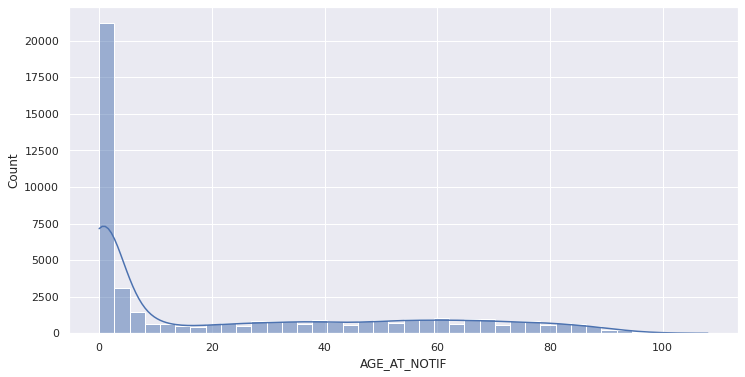

In [11]:
age_col = srag_2019.select(['AGE_AT_NOTIF', 'NU_IDADE_N']).toPandas()
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=age_col, x="AGE_AT_NOTIF", kde=True, palette="GnBu")

<AxesSubplot:xlabel='NU_IDADE_N', ylabel='Count'>

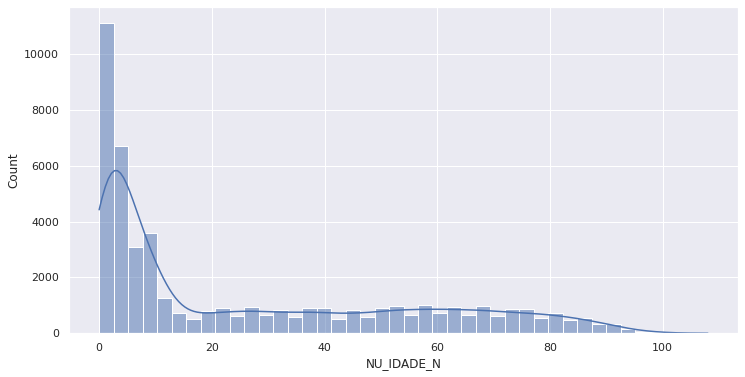

In [12]:
sns.histplot(data=age_col, x="NU_IDADE_N", kde=True, palette="gray")

In [13]:
# how much cases for year in 2019 srag 
srag_2019.select(F.year("DT_NOTIFIC")).groupBy('year(DT_NOTIFIC)').count().show()

+----------------+-----+
|year(DT_NOTIFIC)|count|
+----------------+-----+
|            2018|    3|
|            2019|48286|
|            2020|  265|
+----------------+-----+



<AxesSubplot:xlabel='DT_NOTIFIC', ylabel='count'>

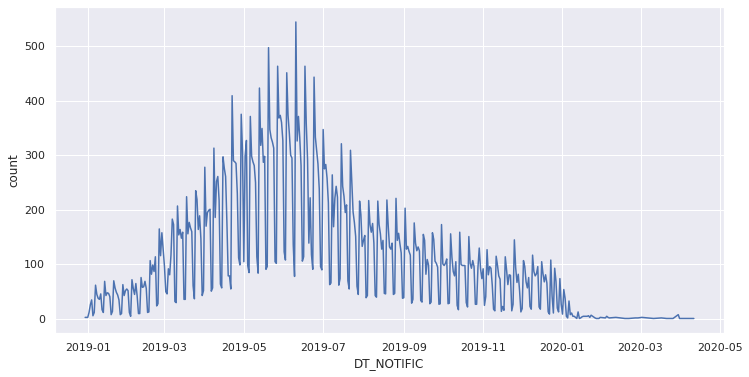

In [14]:
# how much cases for day
daily_cases = srag_2019.select('DT_NOTIFIC').groupby('DT_NOTIFIC').count().orderBy('DT_NOTIFIC').toPandas()
sns.lineplot(data=daily_cases, x="DT_NOTIFIC", y="count")

<AxesSubplot:xlabel='SEM_PRI', ylabel='count'>

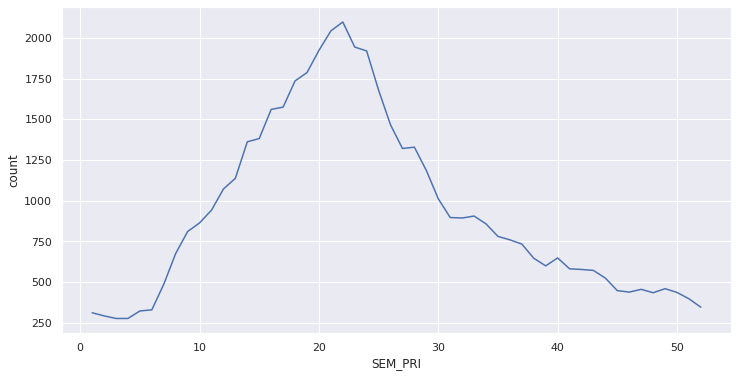

In [15]:
epi_week_cases = srag_2019.select('SEM_PRI').withColumn('SEM_PRI', srag_2019.SEM_PRI.cast(IntegerType()))\
                .groupby('SEM_PRI').count().orderBy('SEM_PRI')\
                .toPandas().dropna()
sns.lineplot(data=epi_week_cases, x="SEM_PRI", y="count")

[Text(0, 0, 'jan'),
 Text(1, 0, 'feb'),
 Text(2, 0, 'apr'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'may'),
 Text(5, 0, 'jun'),
 Text(6, 0, 'jul'),
 Text(7, 0, 'aug'),
 Text(8, 0, 'sep'),
 Text(9, 0, 'oct'),
 Text(10, 0, 'nov'),
 Text(11, 0, 'dec')]

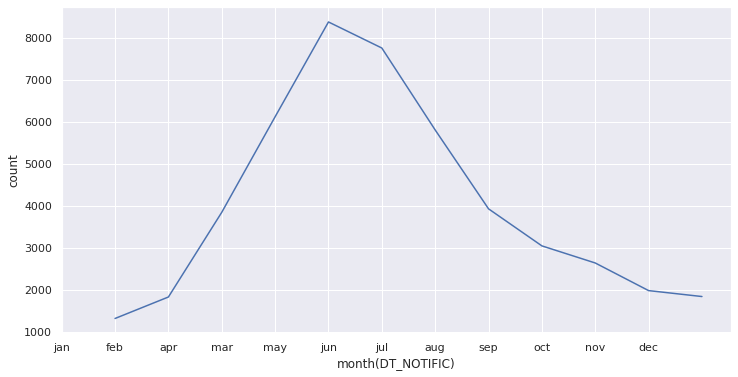

In [16]:
monthly_cases = srag_2019.select('DT_NOTIFIC').groupby(F.month('DT_NOTIFIC')).count().orderBy('month(DT_NOTIFIC)')\
                .toPandas().dropna()
g = sns.lineplot(data=monthly_cases, x="month(DT_NOTIFIC)", y="count")
g.set_xticks(range(len(monthly_cases)))
g.set_xticklabels(['jan','feb','apr','mar','may','jun','jul','aug', 'sep', 'oct', 'nov', 'dec'])

## formating location variables

### some descriptions

In [17]:
srag_2019.select(location_cat_cols).limit(10).toPandas()

,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,ID_REGIONA,CO_REGIONA,SG_UF,ID_MN_RESI,CO_MUN_RES,CS_ZONA,ID_PAIS,CO_PAIS,HISTO_VGM,PAIS_VGM,CO_PS_VGM,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE
0,MG,BELO HORIZONTE,310620,BELO HORIZONTE,1449,MG,RIBEIRAO DAS NEVES,315460,1,BRASIL,1,0,None,None,MG,BELO HORIZONTE,1449,BELO HORIZONTE,310620
1,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,1,BRASIL,1,0,None,None,SP,GVE I CAPITAL,1331,SAO PAULO,355030
2,PE,RECIFE,261160,1,1497,PE,GOIANA,260620,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
3,SP,CAMPINAS,350950,GVE XVII CAMPINAS,1342,SP,CAMPINAS,350950,1,BRASIL,1,0,None,None,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950
4,PE,CARUARU,260410,4,1499,PE,BELO JARDIM,260170,1,BRASIL,1,0,None,None,PE,4,1499,CARUARU,260410
5,PE,RECIFE,261160,1,1497,PE,RECIFE,261160,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
6,MS,CAMPO GRANDE,500270,EX ARS DE CAMPO GRANDE,1975,MS,CAMPO GRANDE,500270,1,BRASIL,1,0,None,None,MS,EX ARS DE CAMPO GRANDE,1975,CAMPO GRANDE,500270
7,PE,RECIFE,261160,1,1497,PE,OLINDA,260960,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
8,PE,RECIFE,261160,1,1497,PE,RECIFE,261160,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160
9,PE,RECIFE,261160,1,1497,PE,IPOJUCA,260720,1,BRASIL,1,0,None,None,PE,1,1497,RECIFE,261160


In [18]:
# how much notification occurred in a municipallity far from patient's residence
srag_2019.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .groupBy('DIFF_MUN').count().show()

+--------------+-----+
|      DIFF_MUN|count|
+--------------+-----+
|DIFFERENT CITY|15601|
|     SAME CITY|32953|
+--------------+-----+



In [19]:
# which state exported more notifications to other cities (in or out the same state)
srag_2019.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .filter(F.col('DIFF_MUN') == 'DIFFERENT CITY').groupBy('SG_UF').count().show()

+-----+-----+
|SG_UF|count|
+-----+-----+
|   SC|  835|
|   RO|   74|
|   PI|  118|
|   AM|  224|
|   RR|    7|
|   GO|  702|
| null|   63|
|   TO|   98|
|   MT|  106|
|   SP| 2835|
|   PB|  162|
|   ES|  409|
|   RS| 1035|
|   MS|  286|
|   AL|   73|
|   MG| 1266|
|   PA|  252|
|   BA|  465|
|   SE|  118|
|   PE| 1494|
+-----+-----+
only showing top 20 rows



<AxesSubplot:>

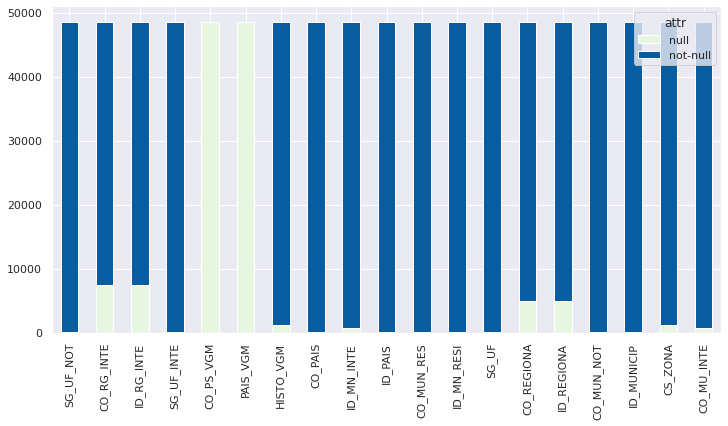

In [20]:
# quantifying nulls
pd_nulls_location_cat_cols = srag_2019.select(location_cat_cols)

# tagging nulls and not nulls values
for col in location_cat_cols:
    pd_nulls_location_cat_cols = pd_nulls_location_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_loc = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in location_cat_cols:
    to_be_joined = pd_nulls_location_cat_cols.select(col).groupby(col).count()
    null_loc = null_loc.join(to_be_joined, null_loc['attr'] == to_be_joined[col], 'left')
    null_loc = null_loc.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_loc = null_loc.withColumnRenamed('count', col)

null_loc = null_loc.toPandas()

# Plotting

null_loc.set_index('attr')\
  .reindex(null_loc.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formating id vars

### some descriptions

<AxesSubplot:>

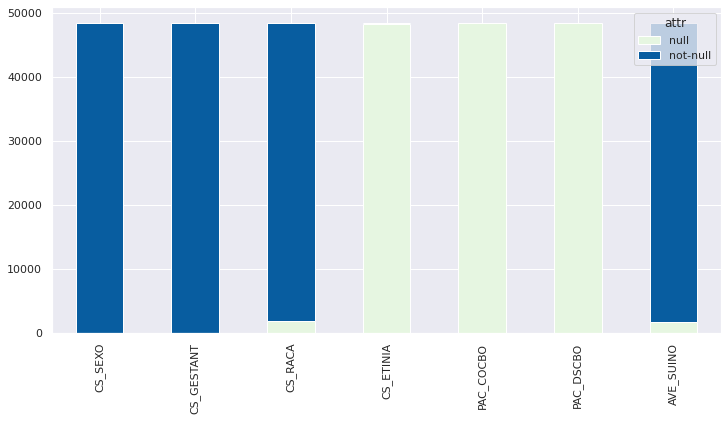

In [21]:
# quantifying nulls
pd_nulls_semi_id_cat_cols = srag_2019.select(semi_id_cat_cols)

# tagging nulls and not nulls values
for col in semi_id_cat_cols:
    pd_nulls_semi_id_cat_cols = pd_nulls_semi_id_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_id = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in semi_id_cat_cols:
    to_be_joined = pd_nulls_semi_id_cat_cols.select(col).groupby(col).count()
    null_id = null_id.join(to_be_joined, null_id['attr'] == to_be_joined[col], 'left')
    null_id = null_id.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_id = null_id.withColumnRenamed('count', col)

null_id = null_id.toPandas()

# Plotting

null_id.set_index('attr')\
  .reindex(null_id.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formatting symptoms variables 

In [22]:
srag_2019.select(symptoms_cat_cols).limit(10).toPandas()

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN
0,1,1,2,1,1,1,2,2,1
1,1,1,2,1,1,1,2,2,2
2,1,1,2,1,1,1,2,2,2
3,1,1,9,1,1,1,2,2,2
4,1,2,2,1,1,1,9,9,2
5,1,1,2,1,1,1,2,2,1
6,1,1,2,1,1,1,2,2,2
7,1,1,2,1,1,1,2,2,2
8,1,1,2,1,1,2,1,1,1
9,1,1,2,1,1,2,2,2,2


### some descriptions

<AxesSubplot:>

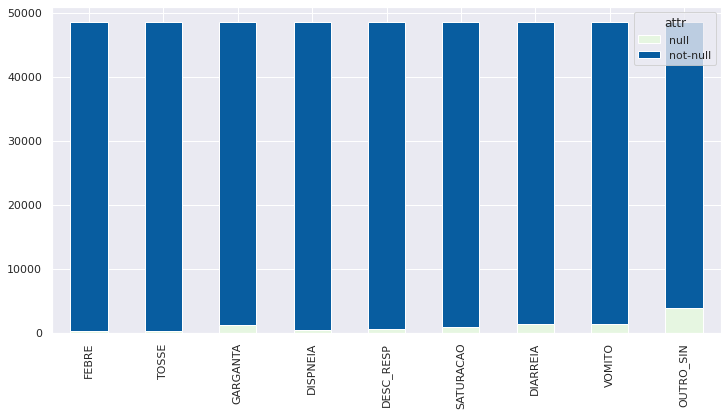

In [23]:
# quantifying nulls
pd_nulls_symptoms_cat_cols = srag_2019.select(symptoms_cat_cols)

# tagging nulls and not nulls values
for col in symptoms_cat_cols:
    pd_nulls_symptoms_cat_cols = pd_nulls_symptoms_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_symp = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in symptoms_cat_cols:
    to_be_joined = pd_nulls_symptoms_cat_cols.select(col).groupby(col).count()
    null_symp = null_symp.join(to_be_joined, null_symp['attr'] == to_be_joined[col], 'left')
    null_symp = null_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_symp = null_symp.withColumnRenamed('count', col)

null_symp = null_symp.toPandas()

# Plotting

null_symp.set_index('attr')\
  .reindex(null_symp.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

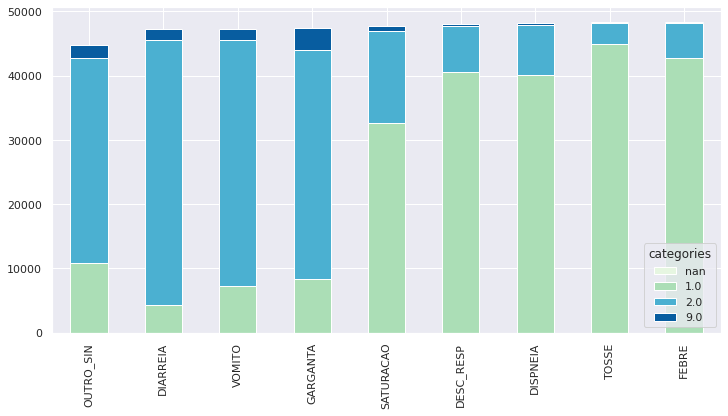

In [24]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
pd_symptoms_cat_cols = srag_2019.select(symptoms_cat_cols)
categories_symp = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in symptoms_cat_cols: 
    to_be_joined = pd_symptoms_cat_cols.select(col).groupby(col).count()
    categories_symp = categories_symp.join(to_be_joined, categories_symp['categories'] == to_be_joined[col], 'left')
    categories_symp = categories_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_symp = categories_symp.withColumnRenamed('count', col)

categories_symp = categories_symp.toPandas()

# Plotting

categories_symp.set_index('categories')\
  .reindex(categories_symp.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  10916


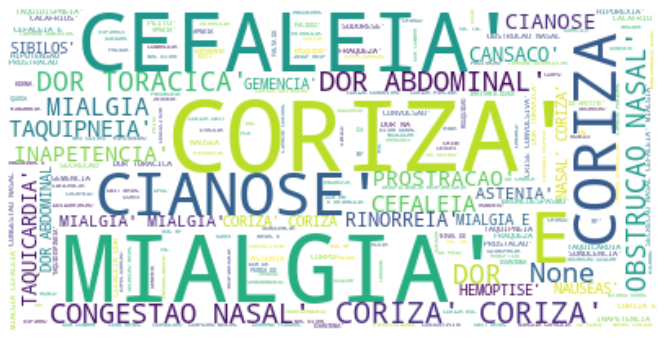

In [25]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_symp_to_wc = srag_2019.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').count())

#Final word cloud after all the cleaning and pre-processing
text = another_symp_to_wc['OUTRO_DES'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting risk factor variables 

In [26]:
srag_2019.select(risk_factor_cat_cols).limit(10).toPandas()

,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI
0,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None,None,None,None,None


### some descriptions

<AxesSubplot:>

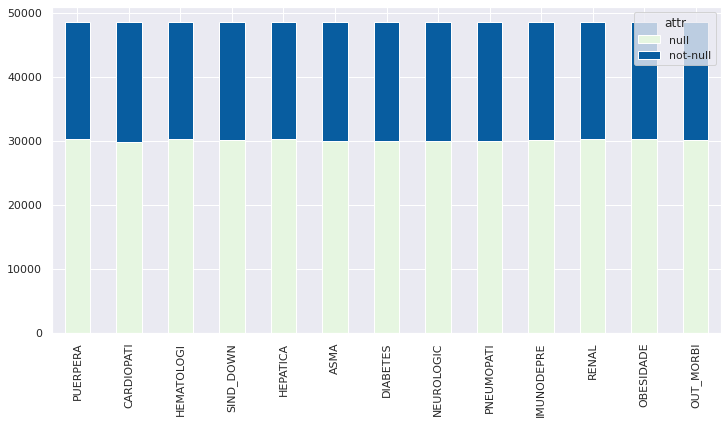

In [27]:
# quantifying nulls
pd_nulls_risk_factor_cat_cols = srag_2019.select(risk_factor_cat_cols)

# tagging nulls and not nulls values
for col in risk_factor_cat_cols:
    pd_nulls_risk_factor_cat_cols = pd_nulls_risk_factor_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_risk = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in risk_factor_cat_cols:
    to_be_joined = pd_nulls_risk_factor_cat_cols.select(col).groupby(col).count()
    null_risk = null_risk.join(to_be_joined, null_risk['attr'] == to_be_joined[col], 'left')
    null_risk = null_risk.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_risk = null_risk.withColumnRenamed('count', col)

null_risk = null_risk.toPandas()

# Plotting

null_risk.set_index('attr')\
  .reindex(null_risk.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

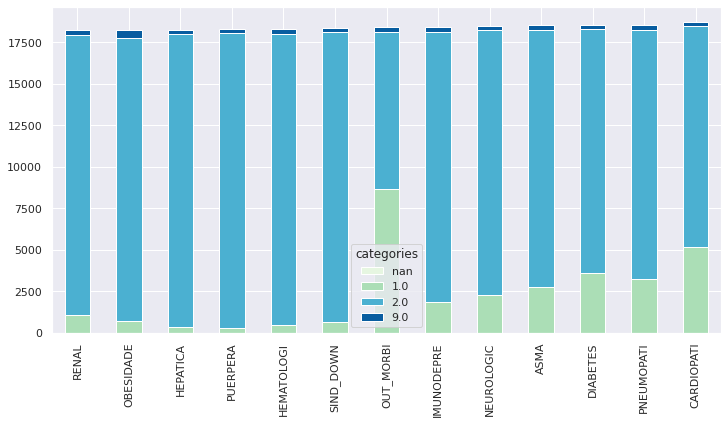

In [28]:
# how distributed are the risk factors
pd_risk_factor = srag_2019.select(risk_factor_cat_cols)
categories_risk_factor = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in risk_factor_cat_cols: 
    to_be_joined = pd_risk_factor.select(col).groupby(col).count()
    categories_risk_factor = categories_risk_factor.join(to_be_joined, categories_risk_factor['categories'] == to_be_joined[col], 'left')
    categories_risk_factor = categories_risk_factor.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_risk_factor = categories_risk_factor.withColumnRenamed('count', col)

categories_risk_factor = categories_risk_factor.toPandas()

# Plotting

categories_risk_factor.set_index('categories')\
  .reindex(categories_risk_factor.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  8651


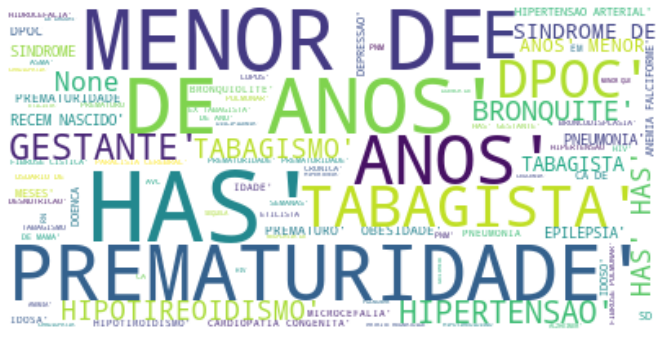

In [29]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_risk_factor_to_wc = srag_2019.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').count())

#Final word cloud after all the cleaning and pre-processing

text = another_risk_factor_to_wc['MORB_DESC'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting case description variables 

In [30]:
srag_2019.select(case_desc_cat_cols).limit(10).toPandas()

,SURTO_SG,NOSOCOMIAL,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,...,POS_PCRFLU,TP_FLU_PCR,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT,LAB_PCR,CO_LAB_PCR,CLASSI_FIN,CRITERIO,EVOLUCAO
0,2,2.0,2,NaN,NaN,1,1.0,1,2,2,...,NaN,None,None,None,NaN,None,NaN,4,3,1
1,9,NaN,2,NaN,NaN,1,1.0,1,1,2,...,NaN,None,None,None,NaN,None,NaN,4,1,1
2,9,9.0,2,NaN,NaN,2,NaN,1,2,2,...,NaN,None,None,None,NaN,LAB CENTRAL DE SAUDE PUB DR MILTON BEZERRA SOBRAL,2712075.0,4,1,1
3,2,2.0,2,NaN,NaN,1,1.0,1,1,2,...,NaN,None,None,None,NaN,None,NaN,2,1,1
4,9,9.0,2,9.0,9.0,2,NaN,1,9,9,...,NaN,None,None,None,NaN,None,NaN,4,1,2
5,9,9.0,9,NaN,NaN,2,NaN,1,2,2,...,NaN,None,None,None,NaN,None,NaN,4,1,1
6,9,9.0,9,NaN,NaN,1,1.0,1,1,2,...,2.0,None,None,None,1.0,POSTO AVANCADO SITIO ALTO,2233878.0,2,1,1
7,9,9.0,1,NaN,NaN,2,NaN,1,2,2,...,NaN,None,None,None,NaN,LAB CENTRAL DE SAUDE PUB DR MILTON BEZERRA SOBRAL,2712075.0,4,1,9
8,9,9.0,2,NaN,NaN,2,NaN,1,1,1,...,NaN,None,None,None,NaN,None,NaN,4,1,1
9,9,9.0,1,NaN,NaN,2,NaN,1,2,3,...,NaN,None,None,None,NaN,LAB CENTRAL DE SAUDE PUB DR MILTON BEZERRA SOBRAL,2712075.0,4,1,9


### some descriptions

<AxesSubplot:>

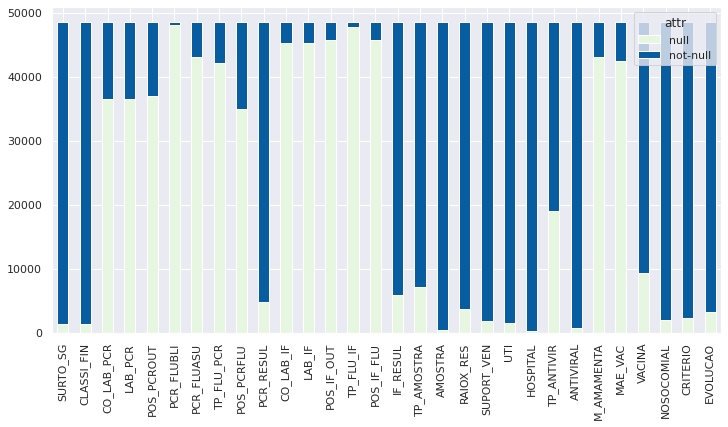

In [31]:
# quantifying nulls
pd_nulls_case_desc_cat_cols = srag_2019.select(case_desc_cat_cols)

# tagging nulls and not nulls values
for col in case_desc_cat_cols:
    pd_nulls_case_desc_cat_cols = pd_nulls_case_desc_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_cases = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in case_desc_cat_cols:
    to_be_joined = pd_nulls_case_desc_cat_cols.select(col).groupby(col).count()
    null_cases = null_cases.join(to_be_joined, null_cases['attr'] == to_be_joined[col], 'left')
    null_cases = null_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_cases = null_cases.withColumnRenamed('count', col)

null_cases = null_cases.toPandas()

# Plotting

null_cases.set_index('attr')\
  .reindex(null_cases.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

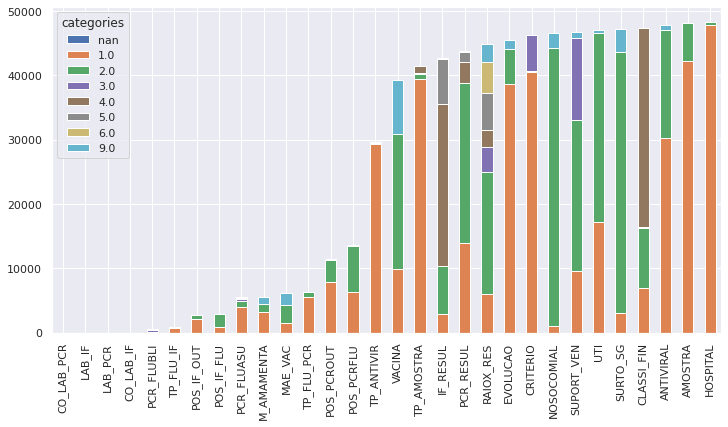

In [32]:
# how distributed are the risk factors
pd_cases = srag_2019.select(case_desc_cat_cols)
categories_cases = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in case_desc_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_cases = categories_cases.join(to_be_joined, categories_cases['categories'] == to_be_joined[col], 'left')
    categories_cases = categories_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_cases = categories_cases.withColumnRenamed('count', col)

categories_cases = categories_cases.toPandas()

# Plotting

categories_cases.set_index('categories')\
  .reindex(categories_cases.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


<hr />

# srag 2020

<hr />

In [19]:
srag_2020 = spark.read.csv('gs://ai-covid19-datalake/raw/srag/2020/srag_2020_24mai.csv', inferSchema=True, header=True, sep=';')

In [20]:
# 2019 has 25769809472 as max value
# 2020 has 68719675014 as max value
# 2021 has 51539820420 as max value
def sum_ids(col, start):
    return col + start
udf_sum_ids = F.udf(sum_ids, LongType())

srag_2020 = srag_2020.withColumn('NU_NOTIFIC', F.monotonically_increasing_id())
srag_2020 = srag_2020.withColumn('NU_NOTIFIC',  udf_sum_ids(F.col('NU_NOTIFIC'), F.lit(25769809473)))

In [21]:
srag_2020.select('NU_NOTIFIC').describe().show()
print('How many distincts: ', srag_2020.select('NU_NOTIFIC').distinct().count())

+-------+--------------------+
|summary|          NU_NOTIFIC|
+-------+--------------------+
|  count|             1193735|
|   mean| 4.71080495404854E10|
| stddev|1.461499771011945...|
|    min|         25769809473|
|    max|         68719675014|
+-------+--------------------+

How many distincts:  1193735


## about the columns

In [22]:
# different columns accross srag years
cols_2019 = srag_2019.columns
cols_2020 = srag_2020.columns
cols_2019.sort()
cols_2020.sort()
diff1 = list(set(cols_2019) - set(cols_2020))
diff2 = list(set(cols_2020) - set(cols_2019))
print('==================================')
print("Columns from 2019 out of 2020 srag version: ", diff1)
print("Number of deleted columns: ", len(diff1))
print('==================================')
print("Columns from 2020 out of 2019 srag version: ", diff2)
print("Number of added columns: ", len(diff2))
print('==================================')

Columns from 2019 out of 2020 srag version:  ['CO_LAB_IF', 'IF_VSR', 'IF_PARA2', 'IF_PARA3', 'OBSERVA', 'IF_RESUL', 'IF_ADENO', 'POS_IF_OUT', 'LAB_IF', 'POS_IF_FLU', 'IF_OUTRO', 'CO_LAB_PCR', 'REQUI_GAL', 'IF_PARA1', 'DT_IF', 'DS_IF_OUT', 'AGE_AT_NOTIF', 'TP_FLU_IF', 'LAB_PCR']
Number of deleted columns:  19
Columns from 2020 out of 2019 srag version:  ['DT_RES', 'OUT_ANIM', 'DS_AN_OUT', 'AN_PARA1', 'AN_ADENO', 'POS_AN_FLU', 'TP_SOR', 'POS_AN_OUT', 'DT_CO_SOR', 'OUT_SOR', 'AN_PARA2', 'TP_AM_SOR', 'FADIGA', 'PERD_OLFT', 'AN_PARA3', 'PERD_PALA', 'DT_RES_AN', 'RES_IGM', 'FATOR_RISC', 'ID_RG_RESI', 'RES_IGA', 'TP_TES_AN', 'AN_SARS2', 'RES_IGG', 'AN_VSR', 'DOR_ABD', 'TOMO_RES', 'TP_FLU_AN', 'DT_TOMO', 'AN_OUTRO', 'SOR_OUT', 'RES_AN', 'TOMO_OUT']
Number of added columns:  33


In [23]:
srag_2020.limit(5).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,NU_NOTIFIC
0,02/01/2020,1,01/01/2020,1,PR,17RS LONDRINA,1371.0,CAMBE,410370,SANTA CASA DE CAMBE,...,None,None,None,None,None,None,None,None,None,25769809473
1,15/01/2020,3,13/01/2020,3,RJ,None,NaN,RIO DE JANEIRO,330455,MS HSE HOSPITAL DOS SERVIDORES DO ESTADO,...,None,None,None,None,None,None,None,None,None,25769809474
2,27/02/2020,9,24/02/2020,9,MG,VARGINHA,1466.0,ITAMONTE,313300,CASA DE CARIDADE DE ITAMONTE,...,None,None,None,None,None,None,None,None,None,25769809475
3,18/02/2020,8,15/02/2020,7,RS,002 CRS,1607.0,PORTO ALEGRE,431490,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,...,None,None,None,None,None,None,None,None,None,25769809476
4,26/02/2020,9,25/02/2020,9,SP,GVE XXVIII CARAGUATATUBA,1576.0,SAO SEBASTIAO,355070,HOSPITAL DE CLINICAS DE SAO SEBASTIAO,...,None,None,None,None,None,None,None,None,None,25769809477


In [24]:
# columns types according to srag dictionary
# date_type: 
date_type_columns = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_VGM', 'DT_RT_VGM', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 
                     'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_EVOLUCA', 'DT_DIGITA', 'DT_RES', 'DT_RES_AN', 'DT_TOMO', 'DT_CO_SOR']


# location categorical cols:
location_cat_cols = ['SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'SG_UF', 'ID_MN_RESI', 'CO_MUN_RES',
                     'CS_ZONA', 'ID_PAIS', 'CO_PAIS', 'HISTO_VGM', 'PAIS_VGM', 'CO_PS_VGM', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE',
                     'ID_MN_INTE', 'CO_MU_INTE']

# semi identifiers 
semi_id_cat_cols = ['NU_NOTIFIC', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'PAC_COCBO', 'PAC_DSCBO', 'AVE_SUINO', 'OUT_ANIM']


# symptoms
symptoms_cat_cols = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'DOR_ABD']


# risk factor 
risk_factor_cat_cols = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 
                        'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'FATOR_RISC']
                                   


# case descriptors
case_desc_cat_cols = ['SURTO_SG', 'NOSOCOMIAL', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'TP_SOR', 
                      'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO']

# test variables
tests_cat_cols = ['RES_IGG', 'RES_IGM', 'RES_IGA', 'RAIOX_RES', 'TOMO_RES', 'AMOSTRA', 'TP_AMOSTRA', 'OUT_SOR', 'SOR_OUT', 'TP_AM_SOR', 
                      'AN_ADENO', 'POS_AN_FLU', 'POS_AN_OUT', 'AN_PARA2', 'AN_PARA3', 'TP_FLU_AN', 'AN_VSR', 'AN_SARS2', 'AN_OUTRO', 'RES_AN', 'TP_FLU_PCR',
                      'PCR_SARS2', 'PCR_RESUL', 'POS_PCRFLU', 'PCR_FLUASU', 'PCR_FLUBLI', 'POS_PCROUT']



# varchar vars (could be id or numerical)
varchar_cols = ['NU_NOTIFIC', 'SEM_PRI', 'NU_IDADE_N', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC', 'OUT_ANTIV', 'RAIOX_OUT', 'OUT_AMOST',
               'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'TOMO_OUT', 'DS_AN_OUT']

In [25]:
srag_2020.printSchema()

root
 |-- DT_NOTIFIC: string (nullable = true)
 |-- SEM_NOT: integer (nullable = true)
 |-- DT_SIN_PRI: string (nullable = true)
 |-- SEM_PRI: integer (nullable = true)
 |-- SG_UF_NOT: string (nullable = true)
 |-- ID_REGIONA: string (nullable = true)
 |-- CO_REGIONA: integer (nullable = true)
 |-- ID_MUNICIP: string (nullable = true)
 |-- CO_MUN_NOT: integer (nullable = true)
 |-- ID_UNIDADE: string (nullable = true)
 |-- CO_UNI_NOT: integer (nullable = true)
 |-- CS_SEXO: string (nullable = true)
 |-- DT_NASC: string (nullable = true)
 |-- NU_IDADE_N: integer (nullable = true)
 |-- TP_IDADE: integer (nullable = true)
 |-- COD_IDADE: string (nullable = true)
 |-- CS_GESTANT: integer (nullable = true)
 |-- CS_RACA: integer (nullable = true)
 |-- CS_ETINIA: string (nullable = true)
 |-- CS_ESCOL_N: integer (nullable = true)
 |-- ID_PAIS: string (nullable = true)
 |-- CO_PAIS: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- ID_RG_RESI: string (nullable = true)
 |-- CO

## Formatting data type variables

In [26]:
# some values on var 'DT_NOTIFIC' has strange values, such as:  "UTI 17/02/2019 04/03/2019" or "DATA INTERNACAO 28/4/19.  20/08/2019- PERMANECE INTERNADA"
# Converting to proper data type on pyspark
before_count = srag_2020.count()
print('Number of lines before date formatting: ', before_count)
for col in date_type_columns:
    srag_2020 = srag_2020.withColumn(col, F.to_date(F.col(col), 'dd/MM/yyyy'))
#     if col == 'DT_NOTIFIC':
#         srag_2020 = srag_2020.filter((F.year(col) != 18) & (F.year(col) != 19) & (F.year(col) != 20) & (F.year(col) != 20))

after_count = srag_2020.count()
print('Number of lines after date formatting: ', srag_2020.count())
total_count = before_count - after_count
print('A total of lines deleted: ', total_count)

Number of lines before date formatting:  1193735
Number of lines after date formatting:  1193735
A total of lines deleted:  0


In [27]:
# Creating 'age' variable from the difference between date of birth and notification event
srag_2020 = srag_2020.withColumn("AGE_AT_NOTIF", F.datediff(F.col('DT_SIN_PRI'), F.col('DT_NASC'))/365.25)\
            .withColumn('AGE_AT_NOTIF', F.floor(F.col('AGE_AT_NOTIF')))

### some descriptions

<AxesSubplot:>

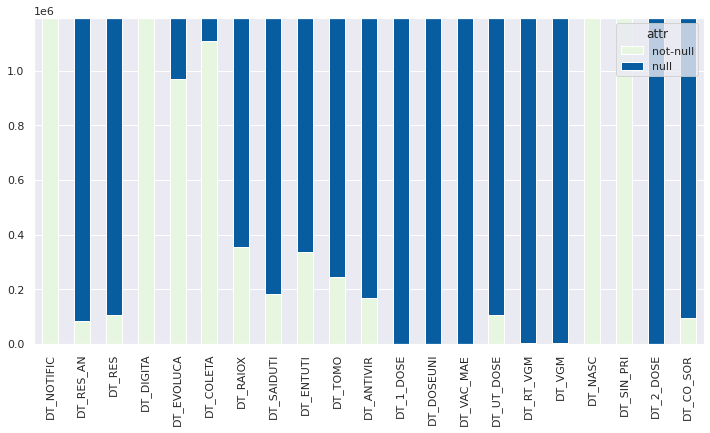

In [40]:
# quantifying nulls
pd_nulls_date_type_cols = srag_2020.select(date_type_columns)

# tagging nulls and not nulls values
for col in date_type_columns:
    pd_nulls_date_type_cols = pd_nulls_date_type_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_dates = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in date_type_columns:
    to_be_joined = pd_nulls_date_type_cols.select(col).groupby(col).count()
    null_dates = null_dates.join(to_be_joined, null_dates['attr'] == to_be_joined[col], 'left')
    null_dates = null_dates.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_dates = null_dates.withColumnRenamed('count', col)

null_dates = null_dates.toPandas()

# Plotting

null_dates.set_index('attr')\
  .reindex(null_dates.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:xlabel='AGE_AT_NOTIF', ylabel='Count'>

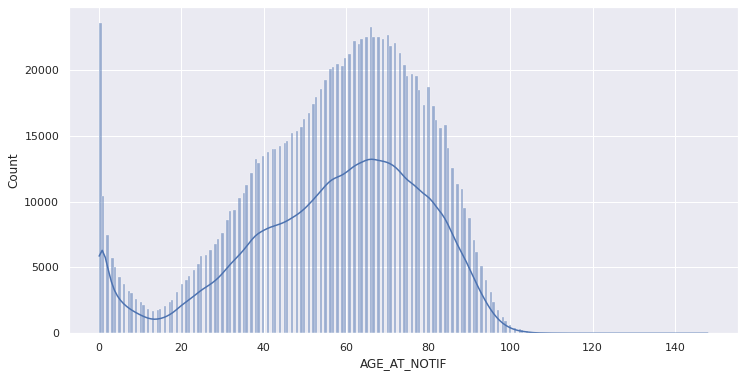

In [41]:
age_col = srag_2020.select(['AGE_AT_NOTIF', 'NU_IDADE_N']).toPandas()
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=age_col, x="AGE_AT_NOTIF", kde=True, palette="GnBu")

<AxesSubplot:xlabel='NU_IDADE_N', ylabel='Count'>

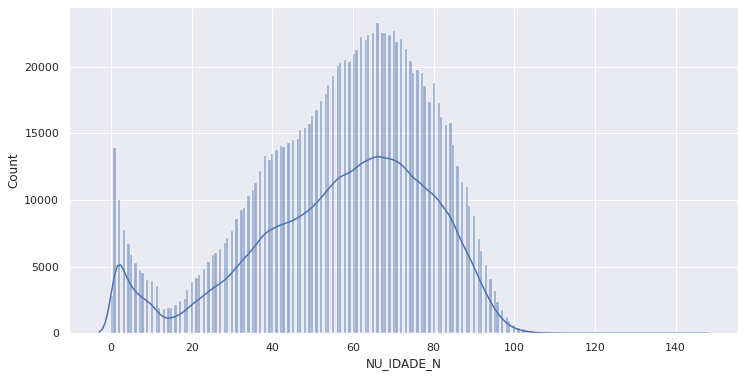

In [42]:
sns.histplot(data=age_col, x="NU_IDADE_N", kde=True, palette="gray")

In [43]:
# how much cases for year in 2019 srag 
srag_2020.select(F.year("DT_NOTIFIC")).groupBy('year(DT_NOTIFIC)').count().show()

+----------------+-------+
|year(DT_NOTIFIC)|  count|
+----------------+-------+
|            2019|     20|
|            2020|1139738|
|            2021|  53977|
+----------------+-------+



<AxesSubplot:xlabel='DT_NOTIFIC', ylabel='count'>

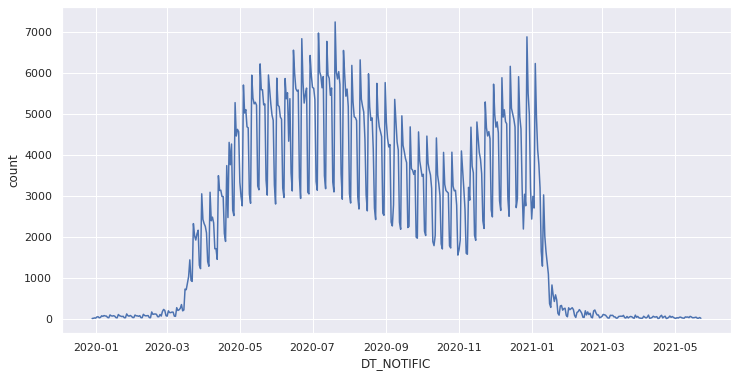

In [44]:
# how much cases for day
daily_cases = srag_2020.select('DT_NOTIFIC').groupby('DT_NOTIFIC').count().orderBy('DT_NOTIFIC').toPandas()
sns.lineplot(data=daily_cases, x="DT_NOTIFIC", y="count")

<AxesSubplot:xlabel='SEM_PRI', ylabel='count'>

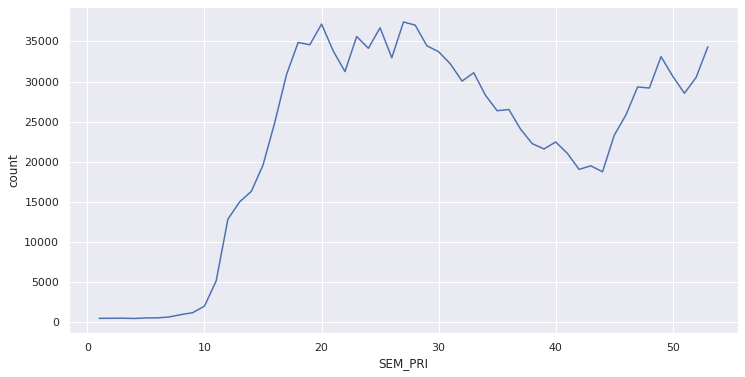

In [45]:
epi_week_cases = srag_2020.select('SEM_PRI').withColumn('SEM_PRI', srag_2020.SEM_PRI.cast(IntegerType()))\
                .groupby('SEM_PRI').count().orderBy('SEM_PRI')\
                .toPandas().dropna()
sns.lineplot(data=epi_week_cases, x="SEM_PRI", y="count")

[Text(0, 0, 'jan'),
 Text(1, 0, 'feb'),
 Text(2, 0, 'apr'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'may'),
 Text(5, 0, 'jun'),
 Text(6, 0, 'jul'),
 Text(7, 0, 'aug'),
 Text(8, 0, 'sep'),
 Text(9, 0, 'oct'),
 Text(10, 0, 'nov'),
 Text(11, 0, 'dec')]

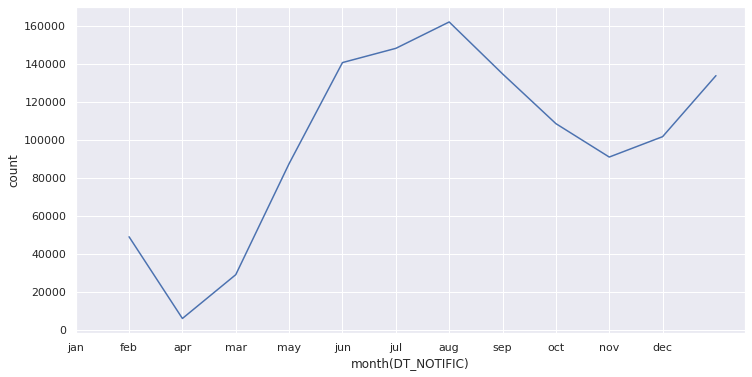

In [46]:
monthly_cases = srag_2020.select('DT_NOTIFIC').groupby(F.month('DT_NOTIFIC')).count().orderBy('month(DT_NOTIFIC)')\
                .toPandas().dropna()
g = sns.lineplot(data=monthly_cases, x="month(DT_NOTIFIC)", y="count")
g.set_xticks(range(len(monthly_cases)))
g.set_xticklabels(['jan','feb','apr','mar','may','jun','jul','aug', 'sep', 'oct', 'nov', 'dec'])

## formating location variables

### some descriptions

In [47]:
srag_2020.select(location_cat_cols).limit(10).toPandas()

,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,ID_REGIONA,CO_REGIONA,SG_UF,ID_MN_RESI,CO_MUN_RES,CS_ZONA,ID_PAIS,CO_PAIS,HISTO_VGM,PAIS_VGM,CO_PS_VGM,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE
0,PR,CAMBE,410370,17RS LONDRINA,1371.0,PR,CAMBE,410370,1,BRASIL,1,0,None,None,PR,17RS LONDRINA,1371.0,CAMBE,410370
1,RJ,RIO DE JANEIRO,330455,None,NaN,RJ,ITAGUAI,330200,3,BRASIL,1,0,None,None,RJ,None,NaN,RIO DE JANEIRO,330455
2,MG,ITAMONTE,313300,VARGINHA,1466.0,MG,ITAMONTE,313300,1,BRASIL,1,2,None,None,MG,VARGINHA,1466.0,ITAMONTE,313300
3,RS,PORTO ALEGRE,431490,002 CRS,1607.0,RS,PORTO ALEGRE,431490,1,BRASIL,1,2,None,None,RS,002 CRS,1607.0,PORTO ALEGRE,431490
4,SP,SAO SEBASTIAO,355070,GVE XXVIII CARAGUATATUBA,1576.0,SP,SAO SEBASTIAO,355070,1,BRASIL,1,2,None,None,SP,None,NaN,SAO SEBASTIAO,355070
5,PR,CURITIBA,410690,02RS METROPOLITANA,1356.0,PR,PIRAQUARA,411950,1,BRASIL,1,2,None,None,PR,02RS METROPOLITANA,1356.0,CURITIBA,410690
6,SP,VOTUPORANGA,355710,GVE XXIX SAO JOSE DO RIO PRETO,1354.0,SP,NHANDEARA,353260,1,BRASIL,1,2,None,None,SP,GVE XXIX SAO JOSE DO RIO PRETO,1354.0,VOTUPORANGA,355710
7,SP,TUPA,355500,GVE XIX MARILIA,1344.0,SP,TUPA,355500,1,BRASIL,1,0,None,None,SP,GVE XIX MARILIA,1344.0,TUPA,355500
8,SP,OSASCO,353440,GVE X OSASCO,1335.0,SP,OSASCO,353440,1,BRASIL,1,2,None,None,SP,GVE X OSASCO,1335.0,OSASCO,353440
9,SP,SAO PAULO,355030,GVE I CAPITAL,1331.0,SP,SAO PAULO,355030,1,BRASIL,1,0,None,None,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030


In [48]:
# how much notification occurred in a municipallity far from patient's residence
srag_2020.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .groupBy('DIFF_MUN').count().show()

+--------------+------+
|      DIFF_MUN| count|
+--------------+------+
|DIFFERENT CITY|331757|
|     SAME CITY|861978|
+--------------+------+



In [49]:
# which state exported more notifications to other cities (in or out the same state)
srag_2020.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .filter(F.col('DIFF_MUN') == 'DIFFERENT CITY').groupBy('SG_UF').count().show()

+-----+-----+
|SG_UF|count|
+-----+-----+
|   SC|13188|
|   RO| 1577|
|   PI| 3695|
|   AM| 2668|
|   RR|  477|
|   GO|12153|
| null|  113|
|   TO| 3022|
|   MT| 4048|
|   SP|80586|
|   PB| 7980|
|   ES| 6145|
|   RS|14439|
|   MS| 2911|
|   AL| 4518|
|   MG|30353|
|   PA| 6878|
|   BA|13371|
|   SE| 4509|
|   PE|25533|
+-----+-----+
only showing top 20 rows



<AxesSubplot:>

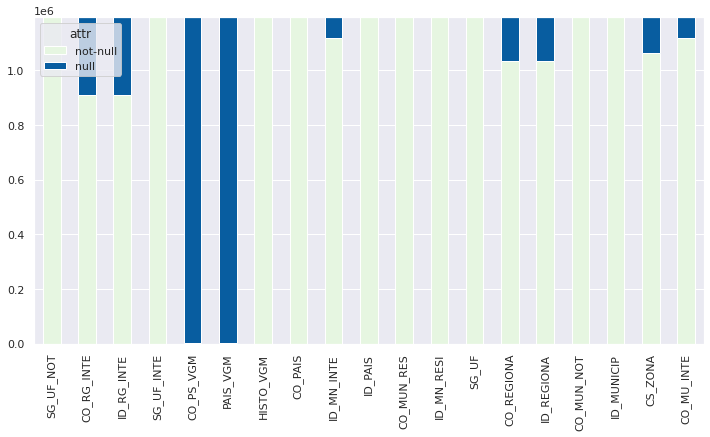

In [50]:
# quantifying nulls
pd_nulls_location_cat_cols = srag_2020.select(location_cat_cols)

# tagging nulls and not nulls values
for col in location_cat_cols:
    pd_nulls_location_cat_cols = pd_nulls_location_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_loc = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in location_cat_cols:
    to_be_joined = pd_nulls_location_cat_cols.select(col).groupby(col).count()
    null_loc = null_loc.join(to_be_joined, null_loc['attr'] == to_be_joined[col], 'left')
    null_loc = null_loc.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_loc = null_loc.withColumnRenamed('count', col)

null_loc = null_loc.toPandas()

# Plotting

null_loc.set_index('attr')\
  .reindex(null_loc.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formating id vars

### some descriptions

<AxesSubplot:>

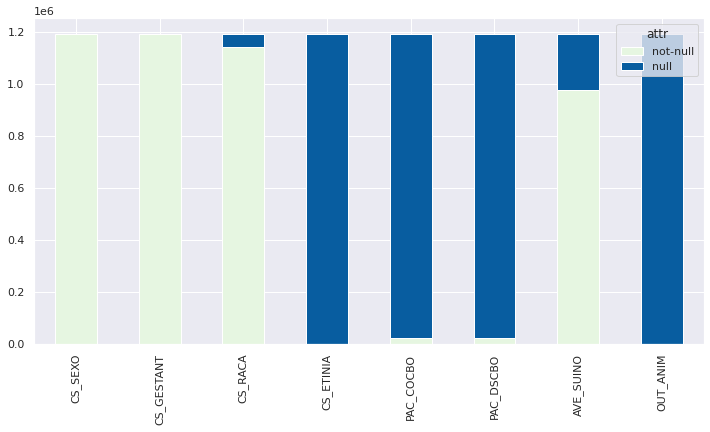

In [51]:
# quantifying nulls
pd_nulls_semi_id_cat_cols = srag_2020.select(semi_id_cat_cols)

# tagging nulls and not nulls values
for col in semi_id_cat_cols:
    pd_nulls_semi_id_cat_cols = pd_nulls_semi_id_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_id = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in semi_id_cat_cols:
    to_be_joined = pd_nulls_semi_id_cat_cols.select(col).groupby(col).count()
    null_id = null_id.join(to_be_joined, null_id['attr'] == to_be_joined[col], 'left')
    null_id = null_id.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_id = null_id.withColumnRenamed('count', col)

null_id = null_id.toPandas()

# Plotting

null_id.set_index('attr')\
  .reindex(null_id.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formatting symptoms variables 

In [52]:
srag_2020.select(symptoms_cat_cols).limit(10).toPandas()

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,FADIGA,PERD_OLFT,PERD_PALA,DOR_ABD
0,1,1,9.0,1,1,9.0,1.0,1.0,9.0,NaN,NaN,NaN,NaN
1,1,1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2.0,1,2,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
3,1,1,2.0,1,1,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN
4,1,1,2.0,1,1,1.0,2.0,2.0,9.0,NaN,NaN,NaN,NaN
5,1,1,2.0,2,1,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
6,1,1,2.0,1,2,1.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN
7,1,1,1.0,1,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
8,1,1,2.0,1,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9,1,1,2.0,1,1,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN


### some descriptions

<AxesSubplot:>

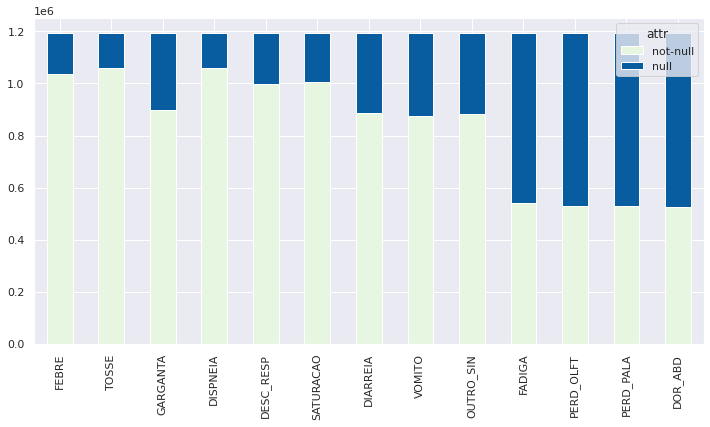

In [53]:
# quantifying nulls
pd_nulls_symptoms_cat_cols = srag_2020.select(symptoms_cat_cols)

# tagging nulls and not nulls values
for col in symptoms_cat_cols:
    pd_nulls_symptoms_cat_cols = pd_nulls_symptoms_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_symp = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in symptoms_cat_cols:
    to_be_joined = pd_nulls_symptoms_cat_cols.select(col).groupby(col).count()
    null_symp = null_symp.join(to_be_joined, null_symp['attr'] == to_be_joined[col], 'left')
    null_symp = null_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_symp = null_symp.withColumnRenamed('count', col)

null_symp = null_symp.toPandas()

# Plotting

null_symp.set_index('attr')\
  .reindex(null_symp.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

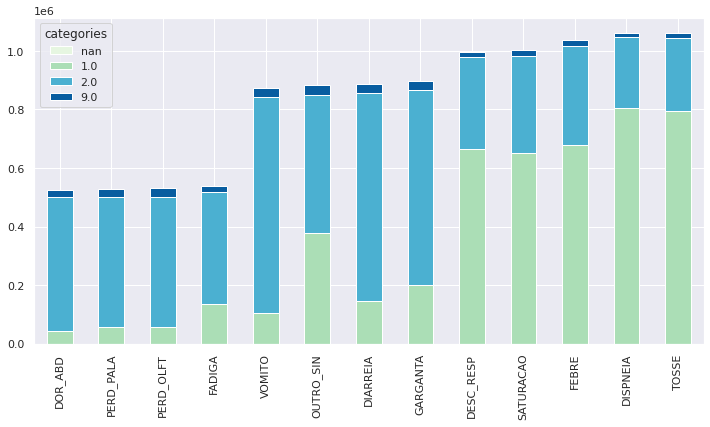

In [54]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
pd_symptoms_cat_cols = srag_2020.select(symptoms_cat_cols)
categories_symp = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in symptoms_cat_cols: 
    to_be_joined = pd_symptoms_cat_cols.select(col).groupby(col).count()
    categories_symp = categories_symp.join(to_be_joined, categories_symp['categories'] == to_be_joined[col], 'left')
    categories_symp = categories_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_symp = categories_symp.withColumnRenamed('count', col)

categories_symp = categories_symp.toPandas()

# Plotting

categories_symp.set_index('categories')\
  .reindex(categories_symp.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  10916


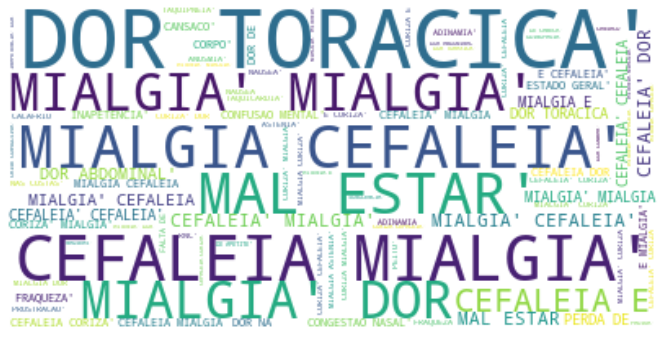

In [55]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_symp_to_wc = srag_2020.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').count())

#Final word cloud after all the cleaning and pre-processing
text = another_symp_to_wc['OUTRO_DES'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting risk factor variables 

In [56]:
srag_2020.select(risk_factor_cat_cols).limit(10).toPandas()

,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,FATOR_RISC
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,S
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
7,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,S
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### some descriptions

<AxesSubplot:>

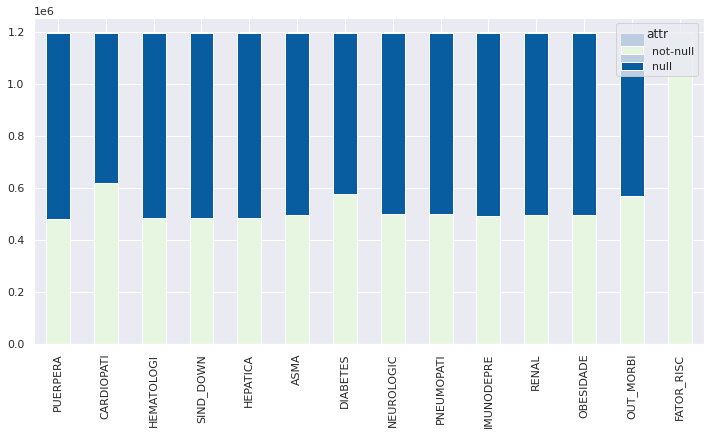

In [57]:
# quantifying nulls
pd_nulls_risk_factor_cat_cols = srag_2020.select(risk_factor_cat_cols)

# tagging nulls and not nulls values
for col in risk_factor_cat_cols:
    pd_nulls_risk_factor_cat_cols = pd_nulls_risk_factor_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_risk = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in risk_factor_cat_cols:
    to_be_joined = pd_nulls_risk_factor_cat_cols.select(col).groupby(col).count()
    null_risk = null_risk.join(to_be_joined, null_risk['attr'] == to_be_joined[col], 'left')
    null_risk = null_risk.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_risk = null_risk.withColumnRenamed('count', col)

null_risk = null_risk.toPandas()

# Plotting

null_risk.set_index('attr')\
  .reindex(null_risk.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

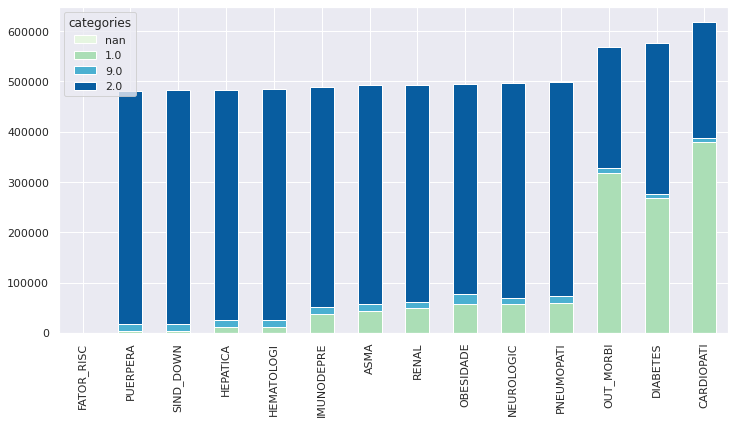

In [58]:
# how distributed are the risk factors
pd_risk_factor = srag_2020.select(risk_factor_cat_cols)
categories_risk_factor = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in risk_factor_cat_cols: 
    to_be_joined = pd_risk_factor.select(col).groupby(col).count()
    categories_risk_factor = categories_risk_factor.join(to_be_joined, categories_risk_factor['categories'] == to_be_joined[col], 'left')
    categories_risk_factor = categories_risk_factor.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_risk_factor = categories_risk_factor.withColumnRenamed('count', col)

categories_risk_factor = categories_risk_factor.toPandas()

# Plotting

categories_risk_factor.set_index('categories')\
  .reindex(categories_risk_factor.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  8651


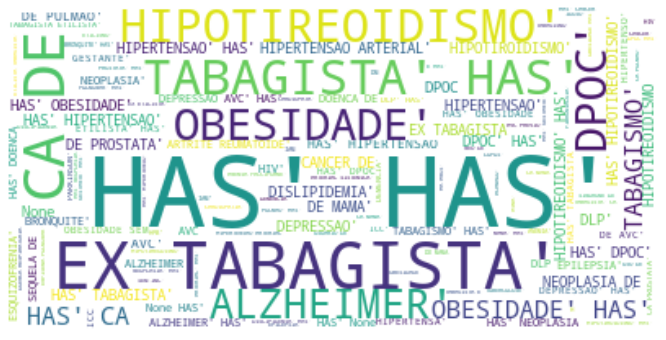

In [59]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_risk_factor_to_wc = srag_2020.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').toPandas()
print('How many cases were filled: ', srag_2019.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').count())

#Final word cloud after all the cleaning and pre-processing

text = another_risk_factor_to_wc['MORB_DESC'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting case description variables 

In [60]:
srag_2020.select(case_desc_cat_cols).limit(10).toPandas()

,SURTO_SG,NOSOCOMIAL,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,TP_SOR,CLASSI_FIN,CRITERIO,EVOLUCAO
0,2,2.0,2.0,NaN,NaN,1.0,1.0,1,1.0,1,None,4,1,3
1,2,2.0,2.0,NaN,NaN,2.0,NaN,1,2.0,3,None,2,1,1
2,2,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,3,None,4,1,1
3,2,2.0,2.0,2.0,1.0,2.0,NaN,1,2.0,3,None,4,1,1
4,9,9.0,2.0,NaN,NaN,2.0,NaN,1,2.0,2,None,4,1,1
5,2,2.0,2.0,NaN,NaN,2.0,NaN,1,2.0,2,None,4,1,1
6,2,2.0,2.0,NaN,NaN,1.0,1.0,1,2.0,2,None,4,1,1
7,2,2.0,2.0,NaN,NaN,2.0,NaN,1,2.0,3,None,4,1,1
8,1,2.0,2.0,NaN,NaN,2.0,NaN,1,1.0,2,None,4,1,1
9,2,2.0,2.0,NaN,NaN,NaN,NaN,1,NaN,2,None,2,1,1


### some descriptions

<AxesSubplot:>

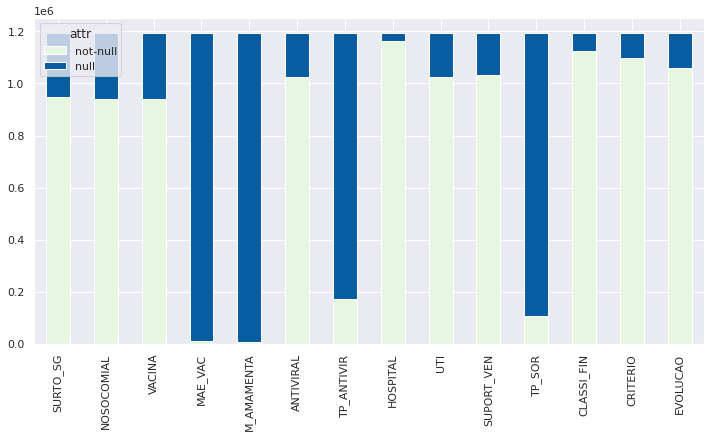

In [61]:
# quantifying nulls
pd_nulls_case_desc_cat_cols = srag_2020.select(case_desc_cat_cols)

# tagging nulls and not nulls values
for col in case_desc_cat_cols:
    pd_nulls_case_desc_cat_cols = pd_nulls_case_desc_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_cases = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in case_desc_cat_cols:
    to_be_joined = pd_nulls_case_desc_cat_cols.select(col).groupby(col).count()
    null_cases = null_cases.join(to_be_joined, null_cases['attr'] == to_be_joined[col], 'left')
    null_cases = null_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_cases = null_cases.withColumnRenamed('count', col)

null_cases = null_cases.toPandas()

# Plotting

null_cases.set_index('attr')\
  .reindex(null_cases.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

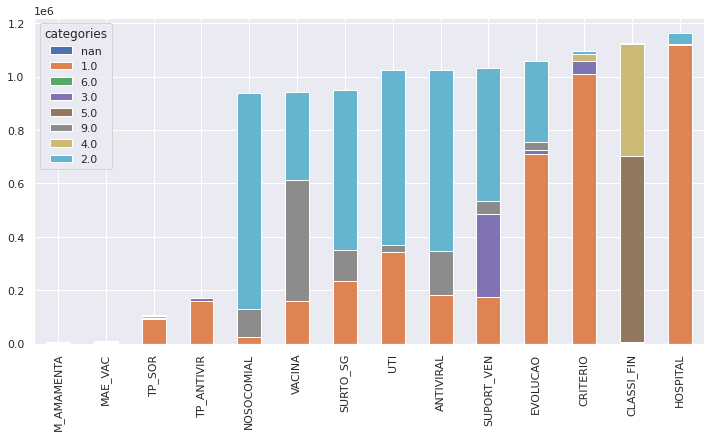

In [62]:
# how distributed are the risk factors
pd_cases = srag_2020.select(case_desc_cat_cols)
categories_cases = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in case_desc_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_cases = categories_cases.join(to_be_joined, categories_cases['categories'] == to_be_joined[col], 'left')
    categories_cases = categories_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_cases = categories_cases.withColumnRenamed('count', col)

categories_cases = categories_cases.toPandas()

# Plotting

categories_cases.set_index('categories')\
  .reindex(categories_cases.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


## formatting tests variables 

In [63]:
srag_2020.select(tests_cat_cols).limit(10).toPandas()

,RES_IGG,RES_IGM,RES_IGA,RAIOX_RES,TOMO_RES,AMOSTRA,TP_AMOSTRA,OUT_SOR,SOR_OUT,TP_AM_SOR,...,AN_SARS2,AN_OUTRO,RES_AN,TP_FLU_PCR,PCR_SARS2,PCR_RESUL,POS_PCRFLU,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT
0,NaN,NaN,NaN,3.0,None,1,1,None,None,None,...,None,None,5.0,None,None,2,NaN,None,None,NaN
1,NaN,NaN,NaN,NaN,None,1,1,None,None,None,...,None,None,4.0,None,None,1,2.0,None,None,1.0
2,NaN,NaN,NaN,2.0,None,1,1,None,None,None,...,None,None,NaN,None,None,2,NaN,None,None,NaN
3,NaN,NaN,NaN,2.0,None,1,1,None,None,None,...,None,None,2.0,None,None,2,NaN,None,None,NaN
4,NaN,NaN,NaN,2.0,None,1,1,None,None,None,...,None,None,2.0,None,None,4,NaN,None,None,NaN
5,NaN,NaN,NaN,6.0,None,1,1,None,None,None,...,None,None,4.0,None,None,2,NaN,None,None,NaN
6,NaN,NaN,NaN,3.0,None,1,1,None,None,None,...,None,None,4.0,None,None,2,NaN,None,None,NaN
7,NaN,NaN,NaN,2.0,None,1,1,None,None,None,...,None,None,4.0,None,None,2,NaN,None,None,NaN
8,4.0,4.0,4.0,2.0,9,1,1,None,None,None,...,None,None,4.0,None,None,2,NaN,None,None,NaN
9,NaN,NaN,NaN,1.0,None,1,1,None,None,None,...,None,None,5.0,None,None,1,NaN,None,None,1.0


### some descriptions

<AxesSubplot:>

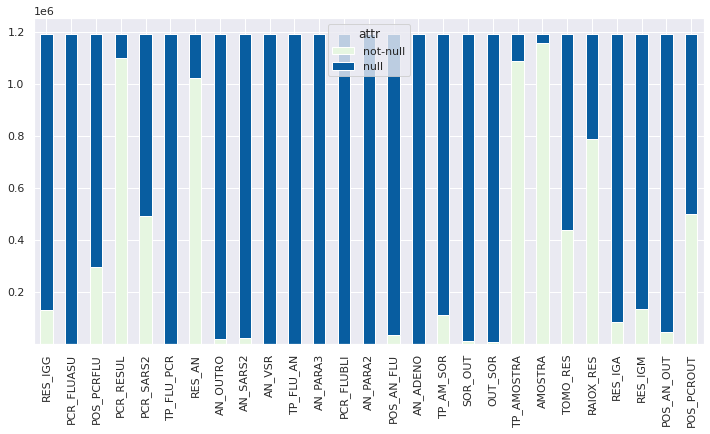

In [64]:
# quantifying nulls
pd_nulls_tests_cat_cols = srag_2020.select(tests_cat_cols)

# tagging nulls and not nulls values
for col in tests_cat_cols:
    pd_nulls_tests_cat_cols = pd_nulls_tests_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_tests = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in tests_cat_cols:
    to_be_joined = pd_nulls_tests_cat_cols.select(col).groupby(col).count()
    null_tests = null_tests.join(to_be_joined, null_tests['attr'] == to_be_joined[col], 'left')
    null_tests = null_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_tests = null_tests.withColumnRenamed('count', col)

null_tests = null_tests.toPandas()

# Plotting

null_tests.set_index('attr')\
  .reindex(null_tests.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

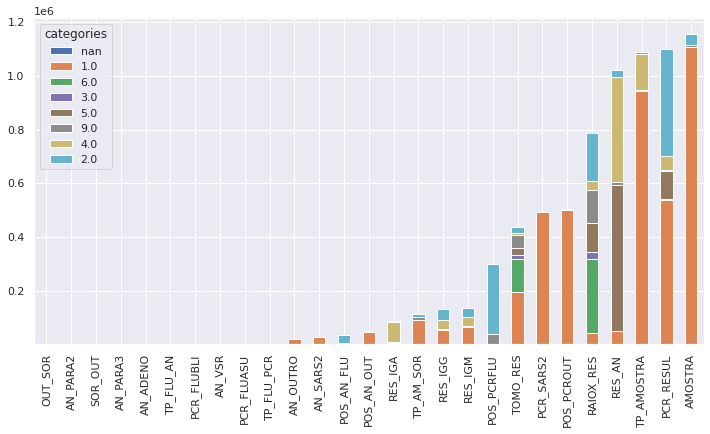

In [65]:
# how distributed are the tests
pd_cases = srag_2020.select(tests_cat_cols)
categories_tests = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in tests_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_tests = categories_tests.join(to_be_joined, categories_tests['categories'] == to_be_joined[col], 'left')
    categories_tests = categories_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_tests = categories_tests.withColumnRenamed('count', col)

categories_tests = categories_tests.toPandas()

# Plotting

categories_tests.set_index('categories')\
  .reindex(categories_tests.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


<hr />

# srag 2021

<hr />

In [28]:
srag_2021 = spark.read.csv('gs://ai-covid19-datalake/raw/srag/2021/srag_2021_24mai.csv', inferSchema=True, header=True, sep=';')

In [29]:
# 2019 has 8589954878 as max value
# 2020 has 68719675014 as max value
# 2021 has 111669486174 as max value
def sum_ids(col, start):
    return col + start
udf_sum_ids = F.udf(sum_ids, LongType())

srag_2021 = srag_2021.withColumn('NU_NOTIFIC', F.monotonically_increasing_id())
srag_2021 = srag_2021.withColumn('NU_NOTIFIC',  udf_sum_ids(F.col('NU_NOTIFIC'), F.lit(68719675015)))

In [37]:
srag_2021.select('NU_NOTIFIC').describe().show()
print('How many distincts: ', srag_2021.select('NU_NOTIFIC').distinct().count())

+-------+--------------------+
|summary|          NU_NOTIFIC|
+-------+--------------------+
|  count|              868367|
|   mean| 9.00014860175749E10|
| stddev|1.459271063165684E10|
|    min|         68719675015|
|    max|        111669486174|
+-------+--------------------+

How many distincts:  868367


## about the columns

In [31]:
# different columns accross srag years
cols_2020 = srag_2020.columns
cols_2021 = srag_2021.columns
cols_2020.sort()
cols_2021.sort()
diff1 = list(set(cols_2020) - set(cols_2021))
diff2 = list(set(cols_2021) - set(cols_2020))
print('==================================')
print("Columns from 2019 out of 2020 srag version: ", diff1)
print("Number of deleted columns: ", len(diff1))
print('==================================')
print("Columns from 2020 out of 2019 srag version: ", diff2)
print("Number of added columns: ", len(diff2))
print('==================================')

Columns from 2019 out of 2020 srag version:  ['AGE_AT_NOTIF']
Number of deleted columns:  1
Columns from 2020 out of 2019 srag version:  []
Number of added columns:  0


In [32]:
srag_2021.limit(5).toPandas()

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,RES_IGG,RES_IGM,RES_IGA,NU_NOTIFIC
0,05/01/2021,1,04/01/2021,1,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380,SALVADOR,292740,HOSPITAL DO SUBURBIO,...,None,None,None,None,None,None,None,None,None,68719675015
1,04/01/2021,1,04/01/2021,1,SP,GVE I CAPITAL,1331,SAO PAULO,355030,HOSPITAL KATIA DE SOUZA RODRIGUES TAIPAS SAO P...,...,None,None,None,None,None,None,None,None,None,68719675016
2,04/01/2021,1,03/01/2021,1,SP,GVE XVII CAMPINAS,1342,CAMPINAS,350950,HOSPITAL E MATERNIDADE CELSO PIERRO,...,None,None,None,None,None,None,None,None,None,68719675017
3,04/01/2021,1,03/01/2021,1,SP,GVE XXVII SAO JOSE DOS CAMPOS,1351,SAO JOSE DOS CAMPOS,354990,DR RUBENS SAVASTANO HOSPITAL REGIONAL DE SAO J...,...,None,None,None,None,None,None,None,None,None,68719675018
4,08/01/2021,1,07/01/2021,1,PR,09RS FOZ DO IGUACU,1363,FOZ DO IGUACU,410830,HOSPITAL MUNICIPAL PADRE GERMANO LAUCK,...,None,None,None,None,None,None,None,None,None,68719675019


In [33]:
# columns types according to srag dictionary
# date_type: 
date_type_columns = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_VGM', 'DT_RT_VGM', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 
                     'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_EVOLUCA', 'DT_DIGITA', 'DT_RES', 'DT_RES_AN', 'DT_TOMO', 'DT_CO_SOR']


# location categorical cols:
location_cat_cols = ['SG_UF_NOT', 'ID_MUNICIP', 'CO_MUN_NOT', 'ID_REGIONA', 'CO_REGIONA', 'SG_UF', 'ID_MN_RESI', 'CO_MUN_RES',
                     'CS_ZONA', 'ID_PAIS', 'CO_PAIS', 'HISTO_VGM', 'PAIS_VGM', 'CO_PS_VGM', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE',
                     'ID_MN_INTE', 'CO_MU_INTE']

# semi identifiers 
semi_id_cat_cols = ['NU_NOTIFIC', 'CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'PAC_COCBO', 'PAC_DSCBO', 'AVE_SUINO', 'OUT_ANIM']


# symptoms
symptoms_cat_cols = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'DOR_ABD']


# risk factor 
risk_factor_cat_cols = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 
                        'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'FATOR_RISC']
                                   


# case descriptors
case_desc_cat_cols = ['SURTO_SG', 'NOSOCOMIAL', 'VACINA', 'MAE_VAC', 'M_AMAMENTA', 'ANTIVIRAL', 'TP_ANTIVIR', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'TP_SOR', 
                      'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO']

# test variables
tests_cat_cols = ['RES_IGG', 'RES_IGM', 'RES_IGA', 'RAIOX_RES', 'TOMO_RES', 'AMOSTRA', 'TP_AMOSTRA', 'OUT_SOR', 'SOR_OUT', 'TP_AM_SOR', 
                      'AN_ADENO', 'POS_AN_FLU', 'POS_AN_OUT', 'AN_PARA2', 'AN_PARA3', 'TP_FLU_AN', 'AN_VSR', 'AN_SARS2', 'AN_OUTRO', 'RES_AN', 'TP_FLU_PCR',
                      'PCR_SARS2', 'PCR_RESUL', 'POS_PCRFLU', 'PCR_FLUASU', 'PCR_FLUBLI', 'POS_PCROUT']



# varchar vars (could be id or numerical)
varchar_cols = ['NU_NOTIFIC', 'SEM_PRI', 'NU_IDADE_N', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC', 'OUT_ANTIV', 'RAIOX_OUT', 'OUT_AMOST',
               'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'CLASSI_OUT', 'TOMO_OUT', 'DS_AN_OUT']

In [34]:
srag_2021.printSchema()

root
 |-- DT_NOTIFIC: string (nullable = true)
 |-- SEM_NOT: integer (nullable = true)
 |-- DT_SIN_PRI: string (nullable = true)
 |-- SEM_PRI: integer (nullable = true)
 |-- SG_UF_NOT: string (nullable = true)
 |-- ID_REGIONA: string (nullable = true)
 |-- CO_REGIONA: integer (nullable = true)
 |-- ID_MUNICIP: string (nullable = true)
 |-- CO_MUN_NOT: integer (nullable = true)
 |-- ID_UNIDADE: string (nullable = true)
 |-- CO_UNI_NOT: integer (nullable = true)
 |-- CS_SEXO: string (nullable = true)
 |-- DT_NASC: string (nullable = true)
 |-- NU_IDADE_N: integer (nullable = true)
 |-- TP_IDADE: integer (nullable = true)
 |-- COD_IDADE: string (nullable = true)
 |-- CS_GESTANT: integer (nullable = true)
 |-- CS_RACA: integer (nullable = true)
 |-- CS_ETINIA: string (nullable = true)
 |-- CS_ESCOL_N: integer (nullable = true)
 |-- ID_PAIS: string (nullable = true)
 |-- CO_PAIS: integer (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- ID_RG_RESI: string (nullable = true)
 |-- CO

## Formatting data type variables

In [35]:
# some values on var 'DT_NOTIFIC' has strange values, such as:  "UTI 17/02/2019 04/03/2019" or "DATA INTERNACAO 28/4/19.  20/08/2019- PERMANECE INTERNADA"
# Converting to proper data type on pyspark
before_count = srag_2021.count()
print('Number of lines before date formatting: ', before_count)
for col in date_type_columns:
    srag_2021 = srag_2021.withColumn(col, F.to_date(F.col(col), 'dd/MM/yyyy'))
#     if col == 'DT_NOTIFIC':
#         srag_2020 = srag_2020.filter((F.year(col) != 18) & (F.year(col) != 19) & (F.year(col) != 20) & (F.year(col) != 20))

after_count = srag_2021.count()
print('Number of lines after date formatting: ', srag_2021.count())
total_count = before_count - after_count
print('A total of lines deleted: ', total_count)

Number of lines before date formatting:  868367
Number of lines after date formatting:  868367
A total of lines deleted:  0


In [36]:
# Creating 'age' variable from the difference between date of birth and notification event
srag_2021 = srag_2021.withColumn("AGE_AT_NOTIF", F.datediff(F.col('DT_SIN_PRI'), F.col('DT_NASC'))/365.25)\
            .withColumn('AGE_AT_NOTIF', F.floor(F.col('AGE_AT_NOTIF')))

### some descriptions

<AxesSubplot:>

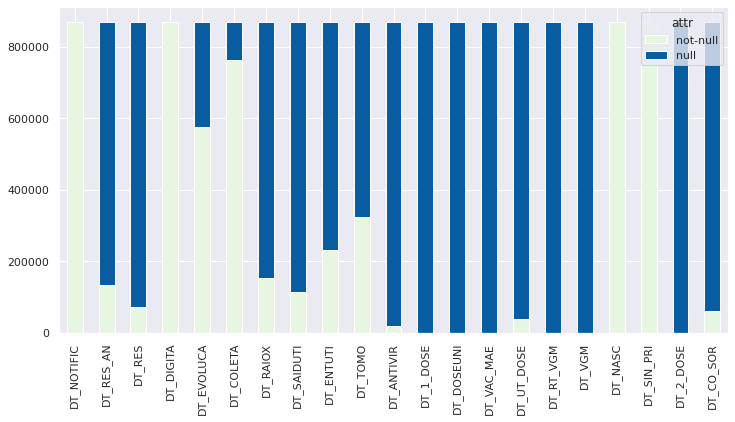

In [73]:
# quantifying nulls
pd_nulls_date_type_cols = srag_2021.select(date_type_columns)

# tagging nulls and not nulls values
for col in date_type_columns:
    pd_nulls_date_type_cols = pd_nulls_date_type_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_dates = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in date_type_columns:
    to_be_joined = pd_nulls_date_type_cols.select(col).groupby(col).count()
    null_dates = null_dates.join(to_be_joined, null_dates['attr'] == to_be_joined[col], 'left')
    null_dates = null_dates.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_dates = null_dates.withColumnRenamed('count', col)

null_dates = null_dates.toPandas()

# Plotting

null_dates.set_index('attr')\
  .reindex(null_dates.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:xlabel='AGE_AT_NOTIF', ylabel='Count'>

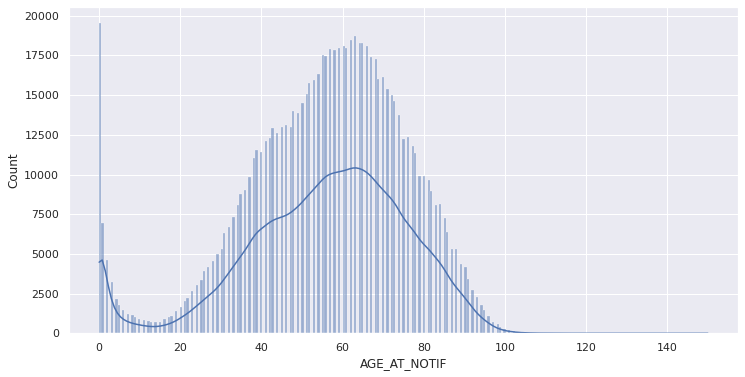

In [74]:
age_col = srag_2021.select(['AGE_AT_NOTIF', 'NU_IDADE_N']).toPandas()
sns.set(rc={'figure.figsize':(12,6)})
sns.histplot(data=age_col, x="AGE_AT_NOTIF", kde=True, palette="GnBu")

<AxesSubplot:xlabel='NU_IDADE_N', ylabel='Count'>

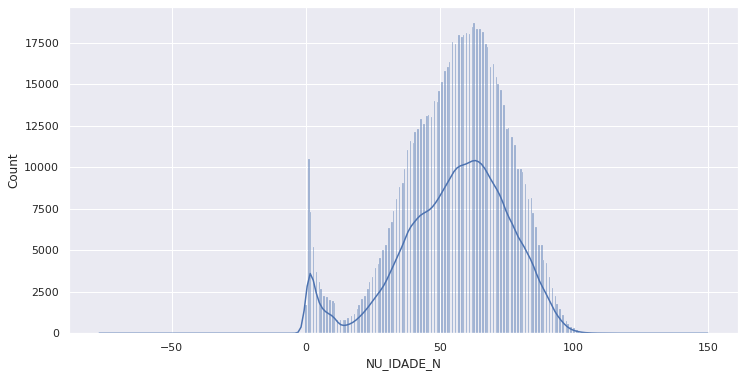

In [75]:
sns.histplot(data=age_col, x="NU_IDADE_N", kde=True, palette="gray")

In [76]:
# how much cases for year in 2019 srag 
srag_2021.select(F.year("DT_NOTIFIC")).groupBy('year(DT_NOTIFIC)').count().show()

+----------------+------+
|year(DT_NOTIFIC)| count|
+----------------+------+
|            2021|868367|
+----------------+------+



<AxesSubplot:xlabel='DT_NOTIFIC', ylabel='count'>

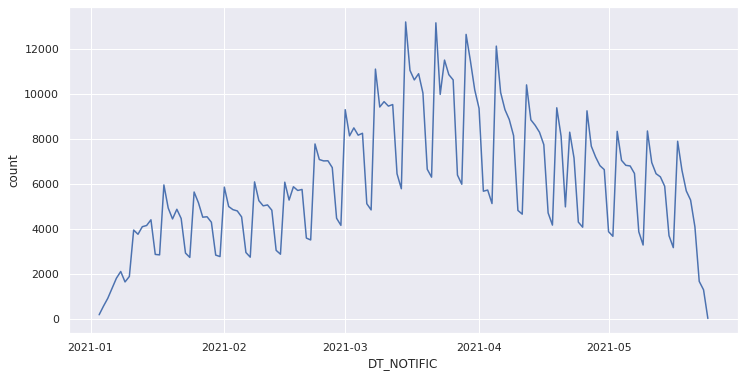

In [77]:
# how much cases for day
daily_cases = srag_2021.select('DT_NOTIFIC').groupby('DT_NOTIFIC').count().orderBy('DT_NOTIFIC').toPandas()
sns.lineplot(data=daily_cases, x="DT_NOTIFIC", y="count")

<AxesSubplot:xlabel='SEM_PRI', ylabel='count'>

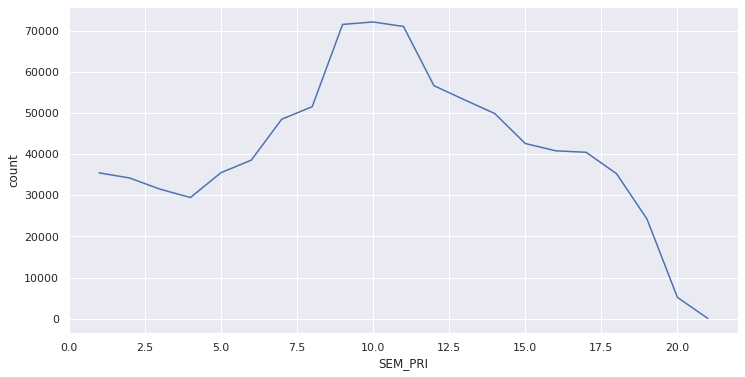

In [78]:
epi_week_cases = srag_2021.select('SEM_PRI').withColumn('SEM_PRI', srag_2021.SEM_PRI.cast(IntegerType()))\
                .groupby('SEM_PRI').count().orderBy('SEM_PRI')\
                .toPandas().dropna()
sns.lineplot(data=epi_week_cases, x="SEM_PRI", y="count")

[Text(0, 0, 'jan'),
 Text(1, 0, 'feb'),
 Text(2, 0, 'apr'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'may')]

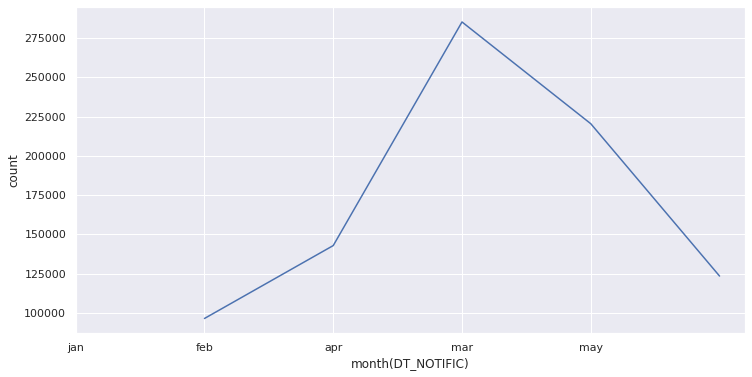

In [79]:
monthly_cases = srag_2021.select('DT_NOTIFIC').groupby(F.month('DT_NOTIFIC')).count().orderBy('month(DT_NOTIFIC)')\
                .toPandas().dropna()
g = sns.lineplot(data=monthly_cases, x="month(DT_NOTIFIC)", y="count")
g.set_xticks(range(len(monthly_cases)))
g.set_xticklabels(['jan','feb','apr','mar','may'])

## formating location variables

### some descriptions

In [80]:
srag_2021.select(location_cat_cols).limit(10).toPandas()

,SG_UF_NOT,ID_MUNICIP,CO_MUN_NOT,ID_REGIONA,CO_REGIONA,SG_UF,ID_MN_RESI,CO_MUN_RES,CS_ZONA,ID_PAIS,CO_PAIS,HISTO_VGM,PAIS_VGM,CO_PS_VGM,SG_UF_INTE,ID_RG_INTE,CO_RG_INTE,ID_MN_INTE,CO_MU_INTE
0,BA,SALVADOR,292740,NUCLEO REGIONAL DE SAUDE LESTE,1380,BA,SALVADOR,292740,1.0,BRASIL,1,2,None,None,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380.0,SALVADOR,292740
1,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,1.0,BRASIL,1,0,None,None,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030
2,SP,CAMPINAS,350950,GVE XVII CAMPINAS,1342,SP,CAMPINAS,350950,1.0,BRASIL,1,2,None,None,SP,GVE XVII CAMPINAS,1342.0,CAMPINAS,350950
3,SP,SAO JOSE DOS CAMPOS,354990,GVE XXVII SAO JOSE DOS CAMPOS,1351,SP,JACAREI,352440,NaN,BRASIL,1,0,None,None,SP,GVE XXVII SAO JOSE DOS CAMPOS,1351.0,SAO JOSE DOS CAMPOS,354990
4,PR,FOZ DO IGUACU,410830,09RS FOZ DO IGUACU,1363,PR,FOZ DO IGUACU,410830,1.0,BRASIL,1,2,None,None,PR,09RS FOZ DO IGUACU,1363.0,FOZ DO IGUACU,410830
5,MG,BARBACENA,310560,BARBACENA,1448,MG,BARBACENA,310560,1.0,BRASIL,1,2,None,None,MG,BARBACENA,1448.0,BARBACENA,310560
6,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,NaN,BRASIL,1,0,None,None,SP,GVE I CAPITAL,1331.0,SAO PAULO,355030
7,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,1.0,BRASIL,1,0,None,None,SP,None,NaN,SAO PAULO,355030
8,SP,SAO PAULO,355030,GVE I CAPITAL,1331,SP,SAO PAULO,355030,NaN,BRASIL,1,0,None,None,SP,None,NaN,SAO PAULO,355030
9,SP,SAO CAETANO DO SUL,354880,GVE VII SANTO ANDRE,1332,SP,SANTO ANDRE,354780,1.0,BRASIL,1,2,None,None,SP,GVE VII SANTO ANDRE,1332.0,SAO CAETANO DO SUL,354880


In [81]:
# how much notification occurred in a municipallity far from patient's residence
srag_2021.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .groupBy('DIFF_MUN').count().show()

+--------------+------+
|      DIFF_MUN| count|
+--------------+------+
|DIFFERENT CITY|246815|
|     SAME CITY|621552|
+--------------+------+



In [82]:
# which state exported more notifications to other cities (in or out the same state)
srag_2021.withColumn('DIFF_MUN', F.when(F.col('CO_MUN_RES') == F.col('CO_MUN_NOT'), F.lit('SAME CITY')).otherwise('DIFFERENT CITY'))\
         .filter(F.col('DIFF_MUN') == 'DIFFERENT CITY').groupBy('SG_UF').count().show()

+-----+-----+
|SG_UF|count|
+-----+-----+
|   SC|13233|
|   RO| 2048|
|   PI| 2513|
|   AM| 1979|
|   RR|  272|
|   GO| 9719|
| null|  104|
|   TO| 2916|
|   MT| 2486|
|   SP|58798|
|   ES| 3154|
|   PB| 6346|
|   RS|13758|
|   MS| 2620|
|   AL| 4140|
|   MG|27048|
|   PA| 4377|
|   BA|10734|
|   SE| 3786|
|   PE| 9007|
+-----+-----+
only showing top 20 rows



<AxesSubplot:>

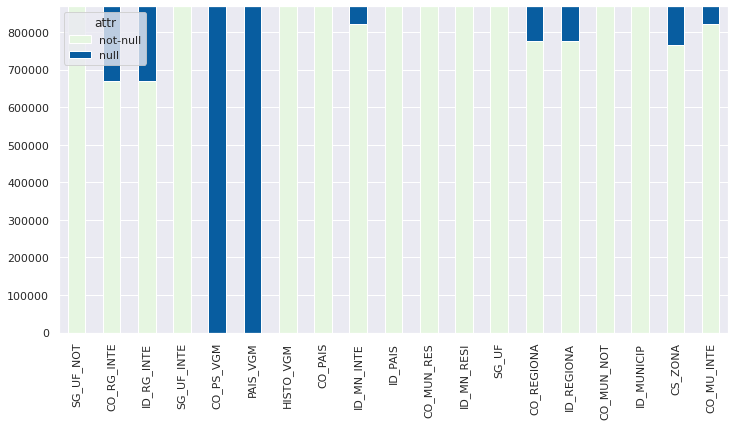

In [83]:
# quantifying nulls
pd_nulls_location_cat_cols = srag_2021.select(location_cat_cols)

# tagging nulls and not nulls values
for col in location_cat_cols:
    pd_nulls_location_cat_cols = pd_nulls_location_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_loc = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in location_cat_cols:
    to_be_joined = pd_nulls_location_cat_cols.select(col).groupby(col).count()
    null_loc = null_loc.join(to_be_joined, null_loc['attr'] == to_be_joined[col], 'left')
    null_loc = null_loc.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_loc = null_loc.withColumnRenamed('count', col)

null_loc = null_loc.toPandas()

# Plotting

null_loc.set_index('attr')\
  .reindex(null_loc.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formating id vars

### some descriptions

<AxesSubplot:>

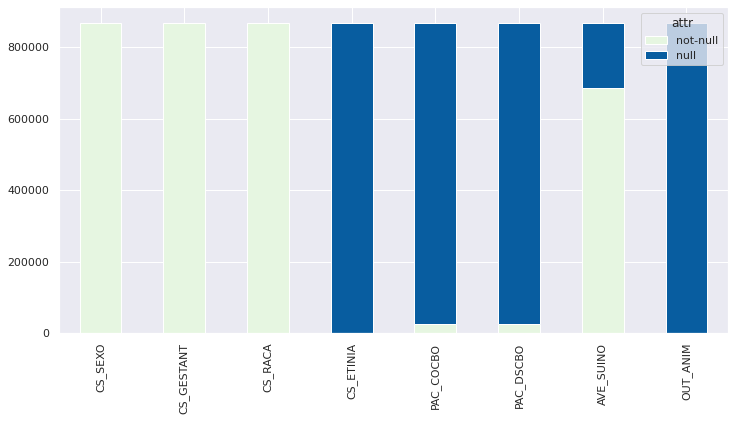

In [84]:
# quantifying nulls
pd_nulls_semi_id_cat_cols = srag_2021.select(semi_id_cat_cols)

# tagging nulls and not nulls values
for col in semi_id_cat_cols:
    pd_nulls_semi_id_cat_cols = pd_nulls_semi_id_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_id = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in semi_id_cat_cols:
    to_be_joined = pd_nulls_semi_id_cat_cols.select(col).groupby(col).count()
    null_id = null_id.join(to_be_joined, null_id['attr'] == to_be_joined[col], 'left')
    null_id = null_id.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_id = null_id.withColumnRenamed('count', col)

null_id = null_id.toPandas()

# Plotting

null_id.set_index('attr')\
  .reindex(null_id.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

## formatting symptoms variables 

In [85]:
srag_2021.select(symptoms_cat_cols).limit(10).toPandas()

,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,FADIGA,PERD_OLFT,PERD_PALA,DOR_ABD
0,1.0,1.0,2.0,1.0,1.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
1,1.0,1.0,2.0,2.0,1.0,2.0,2,2.0,2.0,2.0,2.0,2.0,2.0
2,1.0,1.0,2.0,2.0,1.0,1.0,2,2.0,1.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,1.0,1.0,1.0,2,2.0,NaN,2.0,2.0,2.0,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,2,2.0,1.0,2.0,2.0,2.0,2.0
5,1.0,2.0,2.0,2.0,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0
6,1.0,1.0,2.0,1.0,1.0,1.0,2,2.0,2.0,2.0,2.0,2.0,2.0
7,1.0,NaN,NaN,NaN,NaN,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN
8,1.0,2.0,2.0,1.0,2.0,2.0,2,2.0,2.0,1.0,2.0,2.0,2.0
9,NaN,1.0,NaN,NaN,1.0,1.0,1,NaN,NaN,NaN,1.0,1.0,NaN


### some descriptions

<AxesSubplot:>

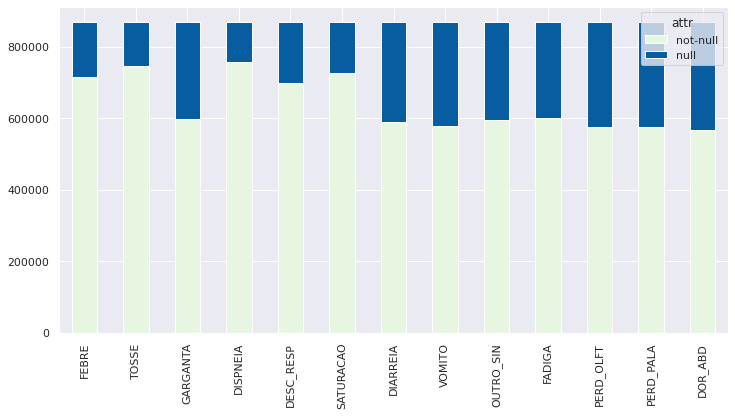

In [86]:
# quantifying nulls
pd_nulls_symptoms_cat_cols = srag_2021.select(symptoms_cat_cols)

# tagging nulls and not nulls values
for col in symptoms_cat_cols:
    pd_nulls_symptoms_cat_cols = pd_nulls_symptoms_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_symp = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in symptoms_cat_cols:
    to_be_joined = pd_nulls_symptoms_cat_cols.select(col).groupby(col).count()
    null_symp = null_symp.join(to_be_joined, null_symp['attr'] == to_be_joined[col], 'left')
    null_symp = null_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_symp = null_symp.withColumnRenamed('count', col)

null_symp = null_symp.toPandas()

# Plotting

null_symp.set_index('attr')\
  .reindex(null_symp.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

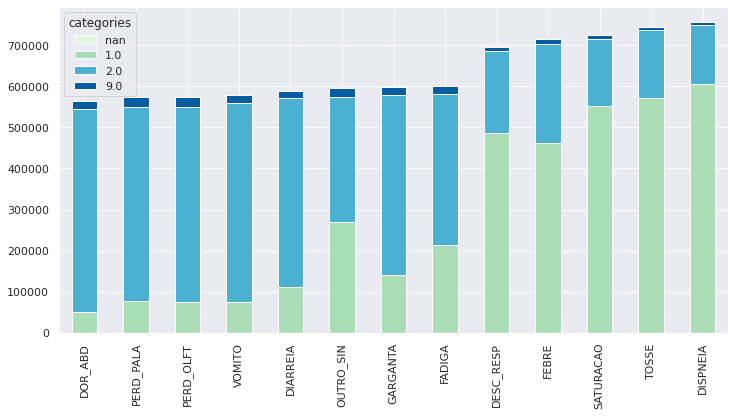

In [87]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
pd_symptoms_cat_cols = srag_2021.select(symptoms_cat_cols)
categories_symp = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in symptoms_cat_cols: 
    to_be_joined = pd_symptoms_cat_cols.select(col).groupby(col).count()
    categories_symp = categories_symp.join(to_be_joined, categories_symp['categories'] == to_be_joined[col], 'left')
    categories_symp = categories_symp.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_symp = categories_symp.withColumnRenamed('count', col)

categories_symp = categories_symp.toPandas()

# Plotting

categories_symp.set_index('categories')\
  .reindex(categories_symp.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  268722


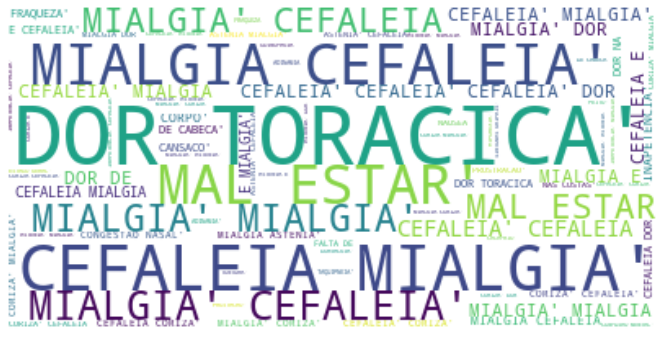

In [88]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_symp_to_wc = srag_2021.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').toPandas()
print('How many cases were filled: ', srag_2021.filter(F.col('OUTRO_SIN') == '1').select('OUTRO_DES').count())

#Final word cloud after all the cleaning and pre-processing
text = another_symp_to_wc['OUTRO_DES'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting risk factor variables 

In [89]:
srag_2021.select(risk_factor_cat_cols).limit(10).toPandas()

,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,FATOR_RISC
0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,S
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,S
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,S
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,S
8,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,S
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### some descriptions

<AxesSubplot:>

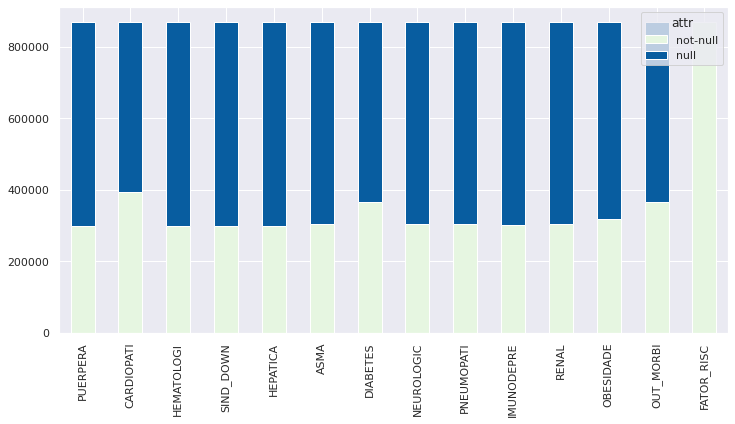

In [90]:
# quantifying nulls
pd_nulls_risk_factor_cat_cols = srag_2021.select(risk_factor_cat_cols)

# tagging nulls and not nulls values
for col in risk_factor_cat_cols:
    pd_nulls_risk_factor_cat_cols = pd_nulls_risk_factor_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_risk = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in risk_factor_cat_cols:
    to_be_joined = pd_nulls_risk_factor_cat_cols.select(col).groupby(col).count()
    null_risk = null_risk.join(to_be_joined, null_risk['attr'] == to_be_joined[col], 'left')
    null_risk = null_risk.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_risk = null_risk.withColumnRenamed('count', col)

null_risk = null_risk.toPandas()

# Plotting

null_risk.set_index('attr')\
  .reindex(null_risk.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

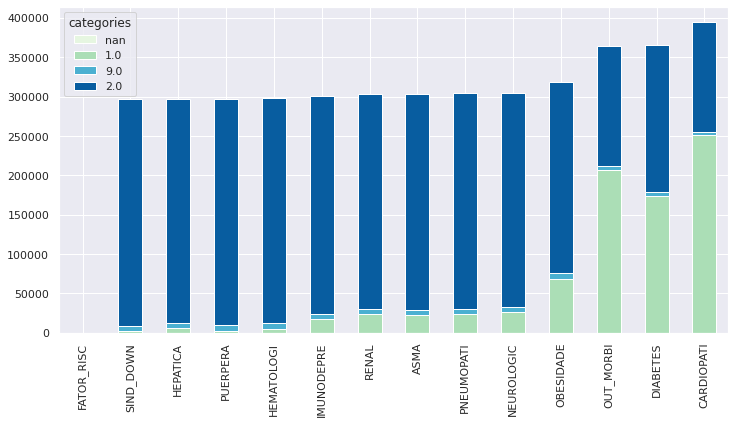

In [91]:
# how distributed are the risk factors
pd_risk_factor = srag_2021.select(risk_factor_cat_cols)
categories_risk_factor = spark.createDataFrame([None, 1, 2, 9], IntegerType()).toDF("categories")
for col in risk_factor_cat_cols: 
    to_be_joined = pd_risk_factor.select(col).groupby(col).count()
    categories_risk_factor = categories_risk_factor.join(to_be_joined, categories_risk_factor['categories'] == to_be_joined[col], 'left')
    categories_risk_factor = categories_risk_factor.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_risk_factor = categories_risk_factor.withColumnRenamed('count', col)

categories_risk_factor = categories_risk_factor.toPandas()

# Plotting

categories_risk_factor.set_index('categories')\
  .reindex(categories_risk_factor.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))


How many cases were filled:  207000


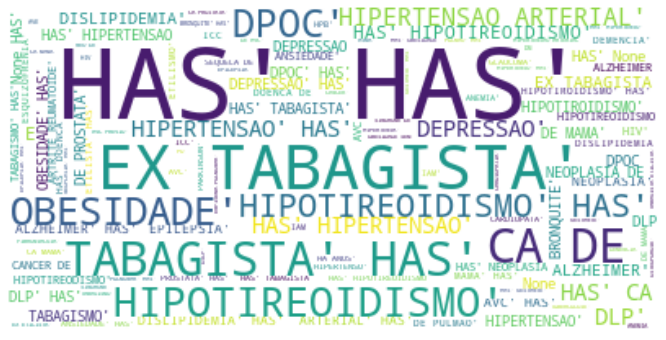

In [92]:
# what are the most popular symptoms when 'OUTROS_SIN' (another symptoms) is set as '1' (yes)
another_risk_factor_to_wc = srag_2021.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').toPandas()
print('How many cases were filled: ', srag_2021.filter(F.col('OUT_MORBI') == '1').select('MORB_DESC').count())

#Final word cloud after all the cleaning and pre-processing

text = another_risk_factor_to_wc['MORB_DESC'].tolist() 

wordcloud = WordCloud(max_font_size=60, max_words=200, background_color="white").generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## formatting case description variables 

In [93]:
srag_2021.select(case_desc_cat_cols).limit(10).toPandas()

,SURTO_SG,NOSOCOMIAL,VACINA,MAE_VAC,M_AMAMENTA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,TP_SOR,CLASSI_FIN,CRITERIO,EVOLUCAO
0,2.0,1.0,9.0,None,None,2.0,None,1,1.0,NaN,None,5,1,1.0
1,2.0,2.0,2.0,None,None,2.0,None,1,2.0,3.0,None,4,1,1.0
2,2.0,2.0,2.0,None,None,2.0,None,1,2.0,2.0,None,4,1,1.0
3,NaN,NaN,NaN,None,None,NaN,None,1,NaN,NaN,None,4,1,NaN
4,2.0,2.0,2.0,None,None,2.0,None,1,2.0,2.0,None,4,1,1.0
5,2.0,2.0,2.0,None,None,2.0,None,1,2.0,3.0,None,4,1,1.0
6,NaN,2.0,2.0,None,None,2.0,None,1,2.0,2.0,None,4,1,2.0
7,NaN,NaN,NaN,None,None,2.0,None,1,2.0,2.0,None,5,1,1.0
8,NaN,NaN,9.0,None,None,9.0,None,1,1.0,9.0,None,5,1,1.0
9,2.0,2.0,9.0,None,None,9.0,None,1,1.0,2.0,None,5,1,1.0


### some descriptions

<AxesSubplot:>

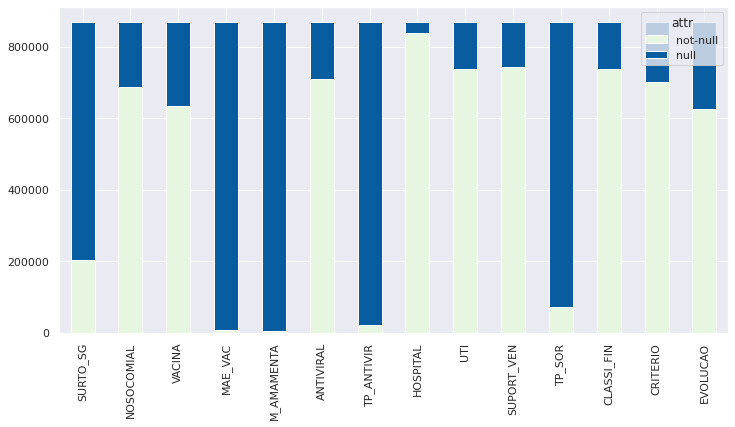

In [94]:
# quantifying nulls
pd_nulls_case_desc_cat_cols = srag_2021.select(case_desc_cat_cols)

# tagging nulls and not nulls values
for col in case_desc_cat_cols:
    pd_nulls_case_desc_cat_cols = pd_nulls_case_desc_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_cases = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in case_desc_cat_cols:
    to_be_joined = pd_nulls_case_desc_cat_cols.select(col).groupby(col).count()
    null_cases = null_cases.join(to_be_joined, null_cases['attr'] == to_be_joined[col], 'left')
    null_cases = null_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_cases = null_cases.withColumnRenamed('count', col)

null_cases = null_cases.toPandas()

# Plotting

null_cases.set_index('attr')\
  .reindex(null_cases.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

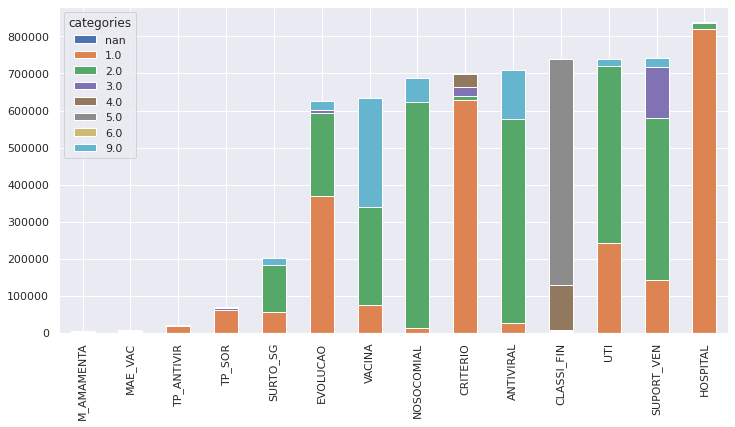

In [95]:
# how distributed are the risk factors
pd_cases = srag_2021.select(case_desc_cat_cols)
categories_cases = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in case_desc_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_cases = categories_cases.join(to_be_joined, categories_cases['categories'] == to_be_joined[col], 'left')
    categories_cases = categories_cases.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_cases = categories_cases.withColumnRenamed('count', col)

categories_cases = categories_cases.toPandas()

# Plotting

categories_cases.set_index('categories')\
  .reindex(categories_cases.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


## formatting tests variables 

In [96]:
srag_2021.select(tests_cat_cols).limit(10).toPandas()

,RES_IGG,RES_IGM,RES_IGA,RAIOX_RES,TOMO_RES,AMOSTRA,TP_AMOSTRA,OUT_SOR,SOR_OUT,TP_AM_SOR,...,AN_SARS2,AN_OUTRO,RES_AN,TP_FLU_PCR,PCR_SARS2,PCR_RESUL,POS_PCRFLU,PCR_FLUASU,PCR_FLUBLI,POS_PCROUT
0,None,None,None,NaN,NaN,1,1,None,None,None,...,None,None,4,None,1.0,1,2.0,None,None,1.0
1,None,None,None,9.0,NaN,1,1,None,None,None,...,None,None,5,None,NaN,2,NaN,None,None,NaN
2,None,None,None,9.0,6.0,1,1,None,None,None,...,None,None,5,None,NaN,2,NaN,None,None,NaN
3,None,None,None,NaN,NaN,1,1,None,None,None,...,None,None,5,None,NaN,2,NaN,None,None,NaN
4,None,None,None,1.0,NaN,1,1,None,None,None,...,None,None,4,None,NaN,2,NaN,None,None,NaN
5,None,None,None,6.0,NaN,1,1,None,None,None,...,None,None,4,None,NaN,2,NaN,None,None,NaN
6,None,None,None,2.0,1.0,1,1,None,None,None,...,None,None,4,None,NaN,2,NaN,None,None,NaN
7,None,None,None,2.0,5.0,1,1,None,None,None,...,None,None,4,None,1.0,1,NaN,None,None,1.0
8,None,None,None,6.0,1.0,1,1,None,None,None,...,None,None,5,None,1.0,1,2.0,None,None,1.0
9,None,None,None,NaN,1.0,1,1,None,None,None,...,None,None,4,None,1.0,1,NaN,None,None,1.0


### some descriptions

<AxesSubplot:>

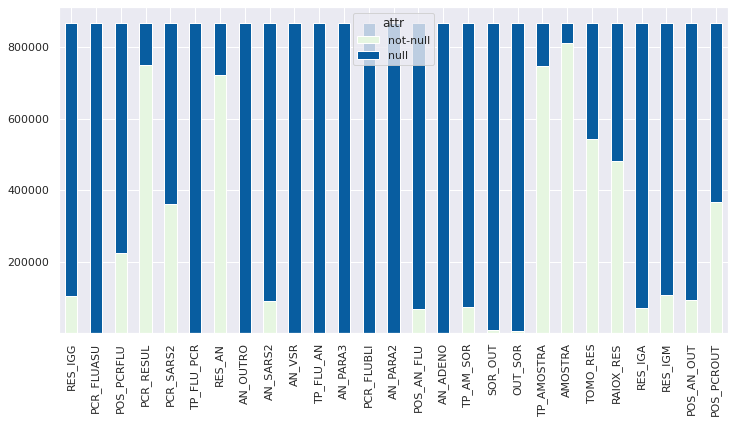

In [97]:
# quantifying nulls
pd_nulls_tests_cat_cols = srag_2021.select(tests_cat_cols)

# tagging nulls and not nulls values
for col in tests_cat_cols:
    pd_nulls_tests_cat_cols = pd_nulls_tests_cat_cols.withColumn(col, F.when(F.col(col).isNotNull(), 'not-null').otherwise('null'))

# creating an pandas data structure to stacked bar plot


null_tests = spark.createDataFrame(["null","not-null"], StringType()).toDF("attr")
for col in tests_cat_cols:
    to_be_joined = pd_nulls_tests_cat_cols.select(col).groupby(col).count()
    null_tests = null_tests.join(to_be_joined, null_tests['attr'] == to_be_joined[col], 'left')
    null_tests = null_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    null_tests = null_tests.withColumnRenamed('count', col)

null_tests = null_tests.toPandas()

# Plotting

null_tests.set_index('attr')\
  .reindex(null_tests.set_index('attr').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(12,6))

<AxesSubplot:>

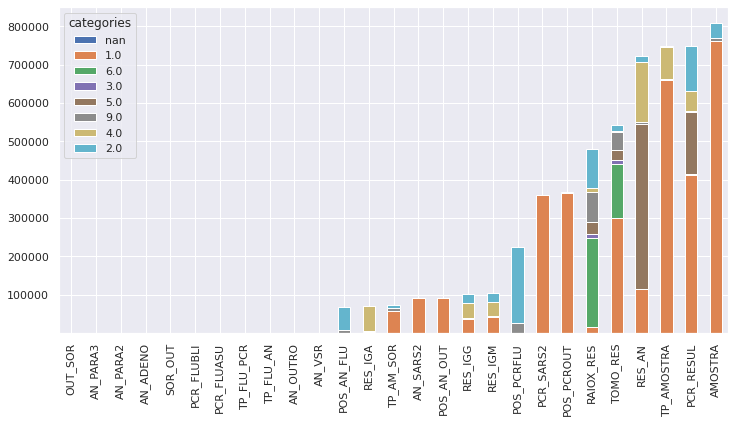

In [98]:
# how distributed are the tests
pd_cases = srag_2021.select(tests_cat_cols)
categories_tests = spark.createDataFrame([None, 1, 2, 3, 4, 5, 6, 9], IntegerType()).toDF("categories")
for col in tests_cat_cols: 
    to_be_joined = pd_cases.select(col).groupby(col).count()
    categories_tests = categories_tests.join(to_be_joined, categories_tests['categories'] == to_be_joined[col], 'left')
    categories_tests = categories_tests.drop(col).withColumn('count', F.when(F.col('count').isNull(), 0).otherwise(F.col('count')))
    categories_tests = categories_tests.withColumnRenamed('count', col)

categories_tests = categories_tests.toPandas()

# Plotting

categories_tests.set_index('categories')\
  .reindex(categories_tests.set_index('categories').sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True,
          colormap=ListedColormap(sns.color_palette()), 
          figsize=(12,6))


<hr />

# Creating first part of Super SRAG dataset

<hr />

## variables of interest

In [52]:
# from 2019
id_cols_2019 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2019 = ['SEM_PRI', 'SEM_NOT', 'DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2019 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2019 = ['PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2019 = ['RAIOX_RES', 'DT_RAIOX', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'IF_RESUL', 'DT_IF', 'POS_IF_FLU', 'TP_FLU_IF', 'POS_IF_OUT', 'IF_VSR', 'IF_PARA1', 'IF_PARA2', 'IF_PARA3', 'IF_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO']

In [53]:
# from 2020
id_cols_2020 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2020 = ['SEM_PRI', 'SEM_NOT','DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2020 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA',
                   'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2020 = ['FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2020 = ['RAIOX_RES', 'DT_RAIOX', 'TOMO_RES', 'DT_TOMO', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'TP_TES_AN', 'DT_RES_AN', 'RES_AN', 'POS_AN_FLU', 'TP_FLU_AN', 'POS_AN_OUT', 'AN_SARS2', 'AN_VSR', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO',
                  'TP_AM_SOR', 'DT_CO_SOR', 'TP_SOR', 'RES_SOR', 'RES_IGG', 'RES_IGM', 'RES_IGA', 'DT_RES']

In [54]:
# from 2021
id_cols_2021 = ['NU_NOTIFIC', 'CS_SEXO', 'AGE_AT_NOTIF', 'CS_GESTANT', 'CS_RACA', 'CS_ETINIA', 'CS_ESCOL_N', 'SG_UF', 'CO_MUN_RES']

epi_cols_2021 = ['SEM_PRI', 'SEM_NOT', 'DT_NOTIFIC', 'DT_SIN_PRI', 'SG_UF_NOT', 'CO_MUN_NOT', 'SURTO_SG', 'NOSOCOMIAL', 'AVE_SUINO', 'VACINA', 
                 'HOSPITAL', 'DT_INTERNA', 'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'CLASSI_FIN', 'CLASSI_OUT', 'CRITERIO',
                  'EVOLUCAO', 'DT_EVOLUCA', 'DT_ENCERRA']

sympt_cols_2021 = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA',
                   'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'OUTRO_DES']

risk_cols_2021 = ['FATOR_RISC', 'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 
                  'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'MORB_DESC']

diag_cols_2021 = ['RAIOX_RES', 'DT_RAIOX', 'TOMO_RES', 'DT_TOMO', 'AMOSTRA', 'TP_AMOSTRA', 'DT_COLETA',
                  'TP_TES_AN', 'DT_RES_AN', 'RES_AN', 'POS_AN_FLU', 'TP_FLU_AN', 'POS_AN_OUT', 'AN_SARS2', 'AN_VSR', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_ADENO',
                  'PCR_RESUL', 'DT_PCR', 'POS_PCRFLU', 'TP_FLU_PCR', 'PCR_FLUASU', 'FLUASU_OUT', 'PCR_FLUBLI', 'FLUBLI_OUT', 'POS_PCROUT', 'PCR_SARS2', 'PCR_VSR', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_ADENO', 'PCR_METAP', 'PCR_BOCA', 'PCR_RINO', 'PCR_OUTRO',
                  'TP_AM_SOR', 'DT_CO_SOR', 'TP_SOR', 'RES_SOR', 'RES_IGG', 'RES_IGM', 'RES_IGA', 'DT_RES']

<hr />

# writing intermediate results

<hr />

In [ ]:
srag_2019.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2019', mode='overwrite')

In [ ]:
srag_2020.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2020', mode='overwrite')

In [ ]:
srag_2021.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021', mode='overwrite')

<hr />

## About tests

<hr />

In [5]:
srag_2019 = spark.read.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2019').repartition(256)

In [6]:
# is the NU_NOTIFIC reliable to be primary key? 
print('how much records do we have? ',srag_2019.count())
print('how manny NU_NOTIFIC are unique? ', srag_2019.select('NU_NOTIFIC').distinct().count())

how much records do we have?  48554
how manny NU_NOTIFIC are unique?  48554


In [7]:
srag_2020 = spark.read.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2020').repartition(256)

In [8]:
# is the NU_NOTIFIC reliable to be primary key? 
print('how much records do we have? ',srag_2020.count())
print('how manny NU_NOTIFIC are unique? ', srag_2020.select('NU_NOTIFIC').distinct().count())

how much records do we have?  1193735
how manny NU_NOTIFIC are unique?  1193735


In [9]:
srag_2021 = spark.read.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021').repartition(256)

In [10]:
# is the NU_NOTIFIC reliable to be primary key? 
print('how much records do we have? ',srag_2021.count())
print('how manny NU_NOTIFIC are unique? ', srag_2021.select('NU_NOTIFIC').distinct().count())

how much records do we have?  868367
how manny NU_NOTIFIC are unique?  868367


## Creating PP_IF_RESUL

### srag_2019

In [11]:
# how was 'IF_RESUL' col before? 
srag_2019.select('IF_RESUL').groupBy('IF_RESUL').count().orderBy('IF_RESUL').show()

+--------+-----+
|IF_RESUL|count|
+--------+-----+
|    null| 5849|
|       1| 2931|
|       2| 7445|
|       3|   17|
|       4|25162|
|       5| 6897|
|       9|  253|
+--------+-----+



In [12]:
srag_2019 = srag_2019.withColumn('PP_IF_RESUL', F.when((F.col('IF_RESUL') == '1') & (F.col('POS_IF_FLU').isNotNull() | F.col('TP_FLU_IF').isNotNull()), '1')\
                                                 .when((F.col('IF_RESUL') == '1') & ((F.col('POS_IF_OUT') == '1') | (F.col('IF_VSR').isNotNull()) | (F.col('IF_PARA1').isNotNull()) | (F.col('IF_PARA3').isNotNull()) | (F.col('IF_ADENO').isNotNull())), '3')\
                                                 .when(F.col('IF_RESUL') == '2', '4')\
                                                 .when(F.col('IF_RESUL') == '3', '5')\
                                                 .when((F.col('IF_RESUL') == '4') | (F.col('IF_RESUL').isNull()), '6')\
                                                 .when(F.col('IF_RESUL') == '5', '7')\
                                                 .otherwise(F.lit('9')))

In [13]:
# how was 'PP_IF_RESUL' col after? 
srag_2019.select('PP_IF_RESUL').groupBy('PP_IF_RESUL').count().orderBy('PP_IF_RESUL').show()

+-----------+-----+
|PP_IF_RESUL|count|
+-----------+-----+
|          1| 2822|
|          3|   88|
|          4| 7445|
|          5|   17|
|          6|31011|
|          7| 6897|
|          9|  274|
+-----------+-----+



### srag_2020

In [14]:
# how was 'TP_TES_AN' col before? 
print("how many records with IF test in srag 2020? ", srag_2020.filter(F.col('TP_TES_AN') == '1').count())
print("how many of those are positive? ", srag_2020.filter((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & (F.col('AN_SARS2').isNotNull()))).count())
srag_2020.filter(F.col('TP_TES_AN') == '1').select('RES_AN').groupBy('RES_AN').count().orderBy('RES_AN').show()

how many records with IF test in srag 2020?  453855
how many of those are positive?  5926
+------+------+
|RES_AN| count|
+------+------+
|  null| 40312|
|     1| 26182|
|     2| 17157|
|     3|   117|
|     4|202088|
|     5|161883|
|     9|  6116|
+------+------+



In [15]:
srag_2020 = srag_2020.withColumn('PP_IF_RESUL', F.when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '3'), '5')\
                                                 .when(((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') != '9') | (F.col('RES_AN').isNotNull()))), '6')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [16]:
# how was 'PP_IF_RESUL' col after? 
srag_2020.select('PP_IF_RESUL').groupBy('PP_IF_RESUL').count().orderBy('PP_IF_RESUL').show()

+-----------+------+
|PP_IF_RESUL| count|
+-----------+------+
|          1|   290|
|          2|  5923|
|          3| 16625|
|          4| 17157|
|          5|   117|
|          6| 32010|
|          7|161883|
|          9|959730|
+-----------+------+



### srag_2021

In [17]:
# how was 'TP_TES_AN' col before? 
print("how many records with IF test in srag 2021? ", srag_2021.filter(F.col('TP_TES_AN') == '1').count())
print("how many of those are positive? ", srag_2021.filter((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & (F.col('AN_SARS2').isNotNull()))).count())
srag_2021.filter(F.col('TP_TES_AN') == '1').select('RES_AN').groupBy('RES_AN').count().orderBy('RES_AN').show()

how many records with IF test in srag 2021?  16997
how many of those are positive?  8013
+------+-----+
|RES_AN|count|
+------+-----+
|  null|  433|
|     1|11095|
|     2| 2141|
|     3|   12|
|     4| 2212|
|     5| 1077|
|     9|   27|
+------+-----+



In [18]:
srag_2021 = srag_2021.withColumn('PP_IF_RESUL', F.when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '1') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '3'), '5')\
                                                 .when(((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') != '9') | (F.col('RES_AN').isNotNull()))), '6')\
                                                 .when((F.col('TP_TES_AN') == '1') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [19]:
# how was 'PP_IF_RESUL' col after? 
srag_2021.select('PP_IF_RESUL').groupBy('PP_IF_RESUL').count().orderBy('PP_IF_RESUL').show()

+-----------+------+
|PP_IF_RESUL| count|
+-----------+------+
|          1|    24|
|          2|  8010|
|          3|   409|
|          4|  2141|
|          5|    12|
|          6|112234|
|          7|  1076|
|          9|744461|
+-----------+------+



## Creating PP_TRA_RESUL

### srag_2019

In [20]:
srag_2019 = srag_2019.withColumn('PP_TRA_RESUL', F.lit('6'))

In [21]:
srag_2019.groupBy('PP_TRA_RESUL').count().orderBy('PP_TRA_RESUL').show()

+------------+-----+
|PP_TRA_RESUL|count|
+------------+-----+
|           6|48554|
+------------+-----+



### srag_2020

In [22]:
srag_2020.filter(F.col('TP_TES_AN') == '2').groupBy('RES_AN').count().orderBy('RES_AN').show()

+------+-----+
|RES_AN|count|
+------+-----+
|  null| 1805|
|     1|22321|
|     2| 7592|
|     3|   33|
|     4| 1035|
|     5|  998|
|     9|   31|
+------+-----+



In [23]:
srag_2020 = srag_2020.withColumn('PP_TRA_RESUL', F.when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '3'), '5')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '4') | (F.col('RES_AN').isNull())), '6')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [24]:
srag_2020.select('PP_TRA_RESUL').groupBy('PP_TRA_RESUL').count().orderBy('PP_TRA_RESUL').show()

+------------+-------+
|PP_TRA_RESUL|  count|
+------------+-------+
|           1|     64|
|           2|  17516|
|           3|    505|
|           4|   7592|
|           5|     33|
|           6|   2777|
|           7|    997|
|           9|1164251|
+------------+-------+



### srag_2021

In [25]:
srag_2021.filter(F.col('TP_TES_AN') == '2').groupBy('RES_AN').count().orderBy('RES_AN').show()

+------+-----+
|RES_AN|count|
+------+-----+
|  null| 2947|
|     1|97928|
|     2|11426|
|     3|   34|
|     4|  897|
|     5| 1864|
|     9|   85|
+------+-----+



In [26]:
srag_2021 = srag_2021.withColumn('PP_TRA_RESUL', F.when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '1') & ((F.col('POS_AN_FLU') == '1') | (F.col('TP_FLU_AN').isNotNull())), '1')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '1') & F.col('AN_SARS2').isNotNull()), '2')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('POS_AN_OUT')== '1') | (F.col('AN_VSR').isNotNull()) | (F.col('AN_PARA1').isNotNull()) | (F.col('AN_PARA2').isNotNull()) | (F.col('AN_PARA3').isNotNull())), '3')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '2'), '4')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '3'), '5')\
                                                 .when((F.col('TP_TES_AN') == '2') & ((F.col('RES_AN') == '4') | (F.col('RES_AN').isNull())), '6')\
                                                 .when((F.col('TP_TES_AN') == '2') & (F.col('RES_AN') == '5'), '7')\
                                                 .otherwise(F.lit('9')))

In [27]:
srag_2021.select('PP_TRA_RESUL').groupBy('PP_TRA_RESUL').count().orderBy('PP_TRA_RESUL').show()

+------------+------+
|PP_TRA_RESUL| count|
+------------+------+
|           1|    73|
|           2| 79609|
|           3|   622|
|           4| 11426|
|           5|    34|
|           6|  3764|
|           7|  1838|
|           9|771001|
+------------+------+



## Creating PP_PCR_RESUL

### srag_2019

In [28]:
# how was 'PCR_RESUL' col before? 
srag_2019.select('PCR_RESUL').groupBy('PCR_RESUL').count().orderBy('PCR_RESUL').show()

+---------+-----+
|PCR_RESUL|count|
+---------+-----+
|     null| 4829|
|        1|14002|
|        2|24735|
|        3|   34|
|        4| 3288|
|        5| 1610|
|        9|   56|
+---------+-----+



In [29]:
srag_2019 = srag_2019.withColumn('PP_PCR_RESUL', F.when((F.col('PCR_RESUL') == '1') & 
                                                        (((F.col('POS_PCRFLU') == '1') | (F.col('TP_FLU_PCR').isNotNull())) |
                                                         ((F.col('PCR_FLUASU').isNotNull()) | (F.col('PCR_FLUASU') == '1') | (F.col('PCR_FLUASU') == '2') | (F.col('PCR_FLUASU') == '3') | (F.col('PCR_FLUASU') == '4') | (F.col('PCR_FLUASU') == '6') | (((F.col('PCR_FLUBLI').isNotNull()) & (F.col('PCR_FLUBLI') != '4'))))), '1')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & (F.col('PCR_SARS2').isNotNull()), '2')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & 
                                                        ((F.col('POS_PCROUT') == '1') | (F.col('PCR_VSR').isNotNull() | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA2').isNotNull()) | (F.col('PCR_PARA3').isNotNull()) | (F.col('PCR_PARA4').isNotNull()) | (F.col('PCR_ADENO').isNotNull()) | (F.col('PCR_METAP').isNotNull())| (F.col('PCR_BOCA').isNotNull())| (F.col('PCR_RINO').isNotNull())| (F.col('PCR_OUTRO').isNotNull()))), '3')\
                                                  .when(F.col('PCR_RESUL') == '2', '4')\
                                                  .when(F.col('PCR_RESUL') == '3', '5')\
                                                  .when((F.col('PCR_RESUL') == '4') | (F.col('PCR_RESUL').isNull()), '6')\
                                                  .when(F.col('PCR_RESUL') == '5', '7')\
                                                  .otherwise(F.lit('9')))            

In [30]:
# how was 'PP_PCR_RESUL' col before? 
srag_2019.select('PP_PCR_RESUL').groupBy('PP_PCR_RESUL').count().orderBy('PP_PCR_RESUL').show()

+------------+-----+
|PP_PCR_RESUL|count|
+------------+-----+
|           1| 6342|
|           2|    1|
|           3| 7626|
|           4|24735|
|           5|   34|
|           6| 8117|
|           7| 1610|
|           9|   89|
+------------+-----+



### srag_2020

In [31]:
# how was 'PCR_RESUL' col before? 
srag_2020.select('PCR_RESUL').groupBy('PCR_RESUL').count().orderBy('PCR_RESUL').show()

+---------+------+
|PCR_RESUL| count|
+---------+------+
|     null| 93334|
|        1|535923|
|        2|397959|
|        3|  5905|
|        4| 52814|
|        5|105148|
|        9|  2652|
+---------+------+



In [32]:
srag_2020 = srag_2020.withColumn('PP_PCR_RESUL', F.when((F.col('PCR_RESUL') == '1') & 
                                                        (((F.col('POS_PCRFLU') == '1') | (F.col('TP_FLU_PCR').isNotNull())) |
                                                         ((F.col('PCR_FLUASU').isNotNull()) | (F.col('PCR_FLUASU') == '1') | (F.col('PCR_FLUASU') == '2') | (F.col('PCR_FLUASU') == '3') | (F.col('PCR_FLUASU') == '4') | (F.col('PCR_FLUASU') == '6') | (((F.col('PCR_FLUBLI').isNotNull()) & (F.col('PCR_FLUBLI') != '4'))))), '1')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & (F.col('PCR_SARS2').isNotNull()), '2')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & 
                                                        ((F.col('POS_PCROUT') == '1') | (F.col('PCR_VSR').isNotNull() | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA2').isNotNull()) | (F.col('PCR_PARA3').isNotNull()) | (F.col('PCR_PARA4').isNotNull()) | (F.col('PCR_ADENO').isNotNull()) | (F.col('PCR_METAP').isNotNull())| (F.col('PCR_BOCA').isNotNull())| (F.col('PCR_RINO').isNotNull())| (F.col('PCR_OUTRO').isNotNull()))), '3')\
                                                  .when(F.col('PCR_RESUL') == '2', '4')\
                                                  .when(F.col('PCR_RESUL') == '3', '5')\
                                                  .when((F.col('PCR_RESUL') == '4') | (F.col('PCR_RESUL').isNull()), '6')\
                                                  .when(F.col('PCR_RESUL') == '5', '7')\
                                                  .otherwise(F.lit('9')))            

In [33]:
# how was 'PP_PCR_RESUL' col before? 
srag_2020.select('PP_PCR_RESUL').groupBy('PP_PCR_RESUL').count().orderBy('PP_PCR_RESUL').show()

+------------+------+
|PP_PCR_RESUL| count|
+------------+------+
|           1|  2005|
|           2|492646|
|           3|  5188|
|           4|397959|
|           5|  5905|
|           6|146148|
|           7|105148|
|           9| 38736|
+------------+------+



### srag_2021

In [34]:
# how was 'PCR_RESUL' col before? 
srag_2021.select('PCR_RESUL').groupBy('PCR_RESUL').count().orderBy('PCR_RESUL').show()

+---------+------+
|PCR_RESUL| count|
+---------+------+
|     null|118922|
|        1|412203|
|        2|116730|
|        3|  2033|
|        4| 53347|
|        5|162717|
|        9|  2415|
+---------+------+



In [35]:
srag_2021 = srag_2021.withColumn('PP_PCR_RESUL', F.when((F.col('PCR_RESUL') == '1') & 
                                                        (((F.col('POS_PCRFLU') == '1') | (F.col('TP_FLU_PCR').isNotNull())) |
                                                         ((F.col('PCR_FLUASU').isNotNull()) | (F.col('PCR_FLUASU') == '1') | (F.col('PCR_FLUASU') == '2') | (F.col('PCR_FLUASU') == '3') | (F.col('PCR_FLUASU') == '4') | (F.col('PCR_FLUASU') == '6') | (((F.col('PCR_FLUBLI').isNotNull()) & (F.col('PCR_FLUBLI') != '4'))))), '1')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & (F.col('PCR_SARS2').isNotNull()), '2')\
                                                  .when((F.col('PCR_RESUL') ==  '1') & 
                                                        ((F.col('POS_PCROUT') == '1') | (F.col('PCR_VSR').isNotNull() | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA1').isNotNull()) | (F.col('PCR_PARA2').isNotNull()) | (F.col('PCR_PARA3').isNotNull()) | (F.col('PCR_PARA4').isNotNull()) | (F.col('PCR_ADENO').isNotNull()) | (F.col('PCR_METAP').isNotNull())| (F.col('PCR_BOCA').isNotNull())| (F.col('PCR_RINO').isNotNull())| (F.col('PCR_OUTRO').isNotNull()))), '3')\
                                                  .when(F.col('PCR_RESUL') == '2', '4')\
                                                  .when(F.col('PCR_RESUL') == '3', '5')\
                                                  .when((F.col('PCR_RESUL') == '4') | (F.col('PCR_RESUL').isNull()), '6')\
                                                  .when(F.col('PCR_RESUL') == '5', '7')\
                                                  .otherwise(F.lit('9')))            

In [36]:
# how was 'PP_PCR_RESUL' col before? 
srag_2021.select('PP_PCR_RESUL').groupBy('PP_PCR_RESUL').count().orderBy('PP_PCR_RESUL').show()

+------------+------+
|PP_PCR_RESUL| count|
+------------+------+
|           1|    56|
|           2|360562|
|           3|  4093|
|           4|116730|
|           5|  2033|
|           6|172269|
|           7|162717|
|           9| 49907|
+------------+------+



## Creating PP_RES_SOR_{IGA, IGM, IGG}

### srag_2019

In [37]:
# there is no IGA test on 2019
srag_2019 = srag_2019.withColumn('PP_RES_SOR_IGA', F.lit('4'))

In [38]:
# there is no IGM test on 2019
srag_2019 = srag_2019.withColumn('PP_RES_SOR_IGM', F.lit('4'))

In [39]:
# there is no IGG test on 2019
srag_2019 = srag_2019.withColumn('PP_RES_SOR_IGG', F.lit('4'))

### srag_2020

In [40]:
# there is no IGA test on 2020
srag_2020 = srag_2020.withColumn('PP_RES_SOR_IGA', F.lit('4'))

In [41]:
# how was 'RES_IGM' col before? 
srag_2020.select('RES_IGM').groupBy('RES_IGM').count().orderBy('RES_IGM').show()

+-------+-------+
|RES_IGM|  count|
+-------+-------+
|   null|1058102|
|      1|  63434|
|      2|  34971|
|      3|    269|
|      4|  34677|
|      5|    175|
|      9|   2107|
+-------+-------+



In [42]:
srag_2020 = srag_2020.withColumnRenamed('RES_IGM', 'PP_RES_SOR_IGM').withColumn('PP_RES_SOR_IGM', 
                                                                                F.when(F.col('PP_RES_SOR_IGM').isNull(), '4').otherwise(F.col('PP_RES_SOR_IGM')))

In [43]:
# how was 'PP_RES_SOR_IGM' col after? 
srag_2020.select('PP_RES_SOR_IGM').groupBy('PP_RES_SOR_IGM').count().orderBy('PP_RES_SOR_IGM').show()

+--------------+-------+
|PP_RES_SOR_IGM|  count|
+--------------+-------+
|             1|  63434|
|             2|  34971|
|             3|    269|
|             4|1092779|
|             5|    175|
|             9|   2107|
+--------------+-------+



In [44]:
# how was 'RES_IGG' col before? 
srag_2020.select('RES_IGG').groupBy('RES_IGG').count().orderBy('RES_IGG').show()

+-------+-------+
|RES_IGG|  count|
+-------+-------+
|   null|1061592|
|      1|  52962|
|      2|  40200|
|      3|    138|
|      4|  36058|
|      5|    222|
|      9|   2563|
+-------+-------+



In [45]:
srag_2020 = srag_2020.withColumnRenamed('RES_IGG', 'PP_RES_SOR_IGG').withColumn('PP_RES_SOR_IGG', 
                                                                                F.when(F.col('PP_RES_SOR_IGG').isNull(), '4').otherwise(F.col('PP_RES_SOR_IGG')))

In [46]:
# how was 'PP_RES_SOR_IGM' col after? 
srag_2020.select('PP_RES_SOR_IGG').groupBy('PP_RES_SOR_IGG').count().orderBy('PP_RES_SOR_IGG').show()

+--------------+-------+
|PP_RES_SOR_IGG|  count|
+--------------+-------+
|             1|  52962|
|             2|  40200|
|             3|    138|
|             4|1097650|
|             5|    222|
|             9|   2563|
+--------------+-------+



### srag 2021

In [47]:
for exam in ['IGA', 'IGM', 'IGG']:
    print('how was RES_' + exam + ' col before?')
    srag_2021.select('RES_'+exam).groupBy('RES_'+exam).count().orderBy('RES_'+exam).show()
    srag_2021 = srag_2021.withColumnRenamed('RES_'+exam, 'PP_RES_SOR_'+exam).withColumn('PP_RES_SOR_'+exam, 
                                                                                F.when(F.col('PP_RES_SOR_'+exam).isNull(), '4').otherwise(F.col('PP_RES_SOR_'+exam)))
    print('how was PP_RES_SOR_' + exam + ' col after?') 
    srag_2021.select('PP_RES_SOR_'+exam).groupBy('PP_RES_SOR_'+exam).count().orderBy('PP_RES_SOR_'+exam).show()

how was RES_IGA col before?
+-------+------+
|RES_IGA| count|
+-------+------+
|   null|796628|
|      1|  2849|
|      2|  2015|
|      3|   221|
|      4| 62936|
|      5|   227|
|      9|  3491|
+-------+------+

how was PP_RES_SOR_IGA col after?
+--------------+------+
|PP_RES_SOR_IGA| count|
+--------------+------+
|             1|  2849|
|             2|  2015|
|             3|   221|
|             4|859564|
|             5|   227|
|             9|  3491|
+--------------+------+

how was RES_IGM col before?
+-------+------+
|RES_IGM| count|
+-------+------+
|   null|762952|
|      1| 42735|
|      2| 22953|
|      3|   148|
|      4| 37836|
|      5|   192|
|      9|  1551|
+-------+------+

how was PP_RES_SOR_IGM col after?
+--------------+------+
|PP_RES_SOR_IGM| count|
+--------------+------+
|             1| 42735|
|             2| 22953|
|             3|   148|
|             4|800788|
|             5|   192|
|             9|  1551|
+--------------+------+

how was RES_IGG co

<hr />

## Creating DIST_DT vars

<hr />

In [48]:
print('how many DT_SIN_PRI are Null: ', srag_2019.filter(F.col('DT_SIN_PRI').isNull()).count())
print('how many DT_SIN_PRI are Null: ', srag_2020.filter(F.col('DT_SIN_PRI').isNull()).count())
print('how many DT_SIN_PRI are Null: ', srag_2021.filter(F.col('DT_SIN_PRI').isNull()).count())
print('All records in both srags: ', srag_2019.count() + srag_2020.count() + srag_2021.count())

how many DT_SIN_PRI are Null:  26
how many DT_SIN_PRI are Null:  0
how many DT_SIN_PRI are Null:  0
All records in both srags:  2110656


In [49]:
# to do: inclue DT_INTERNA at the preprocessing on date type columns
srag_2019 = srag_2019.withColumn('DT_INTERNA', F.to_date(F.col('DT_INTERNA'), 'dd/MM/yyyy'))
srag_2020 = srag_2020.withColumn('DT_INTERNA', F.to_date(F.col('DT_INTERNA'), 'dd/MM/yyyy'))
srag_2021 = srag_2021.withColumn('DT_INTERNA', F.to_date(F.col('DT_INTERNA'), 'dd/MM/yyyy'))

# to do: inclue DT_ENCERRA at the preprocessing on date type columns
srag_2019 = srag_2019.withColumn('DT_ENCERRA', F.to_date(F.col('DT_ENCERRA'), 'dd/MM/yyyy'))
srag_2020 = srag_2020.withColumn('DT_ENCERRA', F.to_date(F.col('DT_ENCERRA'), 'dd/MM/yyyy'))
srag_2021 = srag_2021.withColumn('DT_ENCERRA', F.to_date(F.col('DT_ENCERRA'), 'dd/MM/yyyy'))

# to do: inclue DT_PCR at the preprocessing on date type columns
srag_2019 = srag_2019.withColumn('DT_PCR', F.to_date(F.col('DT_PCR'), 'dd/MM/yyyy'))
srag_2020 = srag_2020.withColumn('DT_PCR', F.to_date(F.col('DT_PCR'), 'dd/MM/yyyy'))
srag_2021 = srag_2021.withColumn('DT_PCR', F.to_date(F.col('DT_PCR'), 'dd/MM/yyyy'))

# to do: inclue DT_IF at the preprocessing on date type columns
srag_2019 = srag_2019.withColumn('DT_IF', F.to_date(F.col('DT_IF'), 'dd/MM/yyyy'))

In [50]:
# Creating date variables exclusive for antigenic and rapid tests on both srag years
srag_2020 = srag_2020.withColumn('DT_IF', F.when(F.col('TP_TES_AN') == '1', F.col('DT_RES_AN')).otherwise(None))
srag_2021 = srag_2021.withColumn('DT_IF', F.when(F.col('TP_TES_AN') == '1', F.col('DT_RES_AN')).otherwise(None))

srag_2019 = srag_2019.withColumn('DT_TRA', F.lit(None).cast('date'))
srag_2020 = srag_2020.withColumn('DT_TRA', F.when(F.col('TP_TES_AN') == '2', F.col('DT_RES_AN')).otherwise(None))
srag_2021 = srag_2021.withColumn('DT_TRA', F.when(F.col('TP_TES_AN') == '2', F.col('DT_RES_AN')).otherwise(None))

In [51]:
# setting cols' names - part 1
event_col = 'DT_SIN_PRI'
dt_cols_convert = {
    'DIST_PRI_NOTIFIC':['DT_NOTIFIC'],
    'DIST_PRI_INTERNA':['DT_INTERNA'],
    'DIST_PRI_ENTUTI':['DT_ENTUTI'],
    'DIST_PRI_SAIDUTI':['DT_SAIDUTI'],
    'DIST_PRI_EVOLUCA':['DT_EVOLUCA'],
    'DIST_PRI_ENCERRA':['DT_ENCERRA'],
    'DIST_PRI_RAIOX':['DT_RAIOX'],
    'DIST_PRI_TOMO':['DT_TOMO'],
    'DIST_PRI_COLETA':['DT_COLETA'],
    'DIST_PRI_SOR':['DT_CO_SOR'],
    'DIST_PRI_PCR':['DT_PCR'],
    'DIST_PRI_TRA':['DT_TRA'],
    'DIST_PRI_IF':['DT_IF']
}

In [52]:
dt_cols = [x[0] for x in dt_cols_convert.values()]

srag_2019 = srag_2019.withColumn('DT_TOMO', F.lit(None).cast(StringType()))
srag_2019 = srag_2019.withColumn('DT_CO_SOR', F.lit(None).cast(StringType()))

all_srags = srag_2019.select(['NU_NOTIFIC'] + [event_col] + dt_cols).union(srag_2020.select(['NU_NOTIFIC'] + [event_col] +  dt_cols)).union(srag_2021.select(['NU_NOTIFIC'] + [event_col] + dt_cols)).repartition(256)

# creating quintiles cuttofs
for col in list(dt_cols_convert.keys()):
    all_srags = all_srags.withColumn(col, F.datediff(F.col(dt_cols_convert[col][0]), F.col(event_col)))
    quint_cut = all_srags.select(col).approxQuantile(col, [0.2, 0.4, 0.6, 0.8], 0)
    dt_cols_convert[col].append(quint_cut)

In [53]:
# Showing the quintiles cuttofs
pd.DataFrame(dt_cols_convert)

,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF
0,DT_NOTIFIC,DT_INTERNA,DT_ENTUTI,DT_SAIDUTI,DT_EVOLUCA,DT_ENCERRA,DT_RAIOX,DT_TOMO,DT_COLETA,DT_CO_SOR,DT_PCR,DT_TRA,DT_IF
1,"[3.0, 5.0, 8.0, 12.0]","[2.0, 4.0, 7.0, 10.0]","[2.0, 5.0, 8.0, 11.0]","[8.0, 13.0, 18.0, 27.0]","[7.0, 12.0, 16.0, 23.0]","[12.0, 18.0, 27.0, 45.0]","[2.0, 4.0, 6.0, 10.0]","[3.0, 6.0, 8.0, 11.0]","[2.0, 3.0, 5.0, 9.0]","[3.0, 6.0, 9.0, 12.0]","[4.0, 6.0, 9.0, 12.0]","[2.0, 3.0, 5.0, 8.0]","[3.0, 6.0, 9.0, 14.0]"


In [54]:
for col in list(dt_cols_convert.keys()):
    all_srags = all_srags.withColumn(col+'_q', F.when(F.col(col) <= dt_cols_convert[col][1][0], '1')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][0]) &  (F.col(col) <= dt_cols_convert[col][1][1]), '2')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][1]) &  (F.col(col) <= dt_cols_convert[col][1][2]), '3')\
                                                                  .when((F.col(col) > dt_cols_convert[col][1][2]) &  (F.col(col) <= dt_cols_convert[col][1][3]), '4')\
                                                                  .when(F.col(col) > dt_cols_convert[col][1][3], '5')\
                                                                  .otherwise('6'))

In [55]:
all_srags.limit(10).toPandas()

,NU_NOTIFIC,DT_SIN_PRI,DT_NOTIFIC,DT_INTERNA,DT_ENTUTI,DT_SAIDUTI,DT_EVOLUCA,DT_ENCERRA,DT_RAIOX,DT_TOMO,DT_COLETA,DT_CO_SOR,DT_PCR,DT_TRA,DT_IF,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,34359826999,2020-06-14,2020-06-19,2020-06-19,None,None,2020-06-19,2020-06-23,None,None,2020-06-19,None,None,None,2020-06-19,5,5.0,NaN,NaN,5.0,9.0,NaN,None,5.0,NaN,NaN,None,5.0,2,3,6,6,1,1,6,6,3,6,6,6,2
1,42949819734,2020-08-10,2020-08-11,2020-08-10,None,None,2020-08-13,2020-10-15,None,None,2020-08-10,None,2020-08-12,None,None,1,0.0,NaN,NaN,3.0,66.0,NaN,None,0.0,NaN,2.0,None,NaN,1,1,6,6,1,5,6,6,1,6,1,6,6
2,25769820210,2020-04-25,2020-05-02,2020-05-01,None,None,2020-05-09,2020-05-13,None,None,2020-04-25,None,2020-05-02,None,None,7,6.0,NaN,NaN,14.0,18.0,NaN,None,0.0,NaN,7.0,None,NaN,3,3,6,6,3,2,6,6,1,6,3,6,6
3,42949876985,2020-07-15,2020-07-24,2020-07-22,2020-07-22,2020-07-31,2020-08-12,2020-08-15,2020-07-22,None,2020-07-22,None,2020-07-24,None,None,9,7.0,7.0,16.0,28.0,31.0,7.0,None,7.0,NaN,9.0,None,NaN,4,3,3,3,5,4,4,6,4,6,3,6,6
4,60129707890,2020-05-19,2020-07-15,2020-05-30,None,None,2020-06-06,2020-07-15,None,None,2020-05-27,None,2020-05-30,None,None,57,11.0,NaN,NaN,18.0,57.0,NaN,None,8.0,NaN,11.0,None,NaN,5,5,6,6,4,5,6,6,4,6,4,6,6
5,25770028484,2020-07-12,2020-07-19,2020-07-18,None,None,2020-07-21,2020-08-24,2020-07-18,None,2020-07-18,None,2020-07-23,None,None,7,6.0,NaN,NaN,9.0,43.0,6.0,None,6.0,NaN,11.0,None,NaN,3,3,6,6,2,4,3,6,4,6,4,6,6
6,51539683382,2020-07-13,2020-07-23,2020-07-22,2020-07-22,None,2020-07-27,2020-11-04,None,None,2020-07-22,None,2020-07-24,None,None,10,9.0,9.0,NaN,14.0,114.0,NaN,None,9.0,NaN,11.0,None,NaN,4,4,4,6,3,5,6,6,4,6,4,6,6
7,51539855584,2020-05-21,2020-05-22,2020-05-22,None,None,2020-05-22,2020-06-04,None,None,2020-05-22,2020-05-22,2020-05-22,None,None,1,1.0,NaN,NaN,1.0,14.0,NaN,None,1.0,1.0,1.0,None,NaN,1,1,6,6,1,2,6,6,1,1,1,6,6
8,42949694264,2020-09-10,2020-09-20,None,None,None,None,None,None,None,None,None,None,None,None,10,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,NaN,4,6,6,6,6,6,6,6,6,6,6,6,6
9,42949757101,2020-05-15,2020-05-19,None,None,None,2020-05-19,2020-07-23,None,None,2020-05-19,None,2020-05-25,None,None,4,NaN,NaN,NaN,4.0,69.0,NaN,None,4.0,NaN,10.0,None,NaN,2,6,6,6,1,5,6,6,3,6,4,6,6


In [56]:
interest_list = all_srags.columns
for col in dt_cols:
    interest_list.remove(col)
interest_list.remove('DT_SIN_PRI')

In [57]:
interest_list

['NU_NOTIFIC',
 'DIST_PRI_NOTIFIC',
 'DIST_PRI_INTERNA',
 'DIST_PRI_ENTUTI',
 'DIST_PRI_SAIDUTI',
 'DIST_PRI_EVOLUCA',
 'DIST_PRI_ENCERRA',
 'DIST_PRI_RAIOX',
 'DIST_PRI_TOMO',
 'DIST_PRI_COLETA',
 'DIST_PRI_SOR',
 'DIST_PRI_PCR',
 'DIST_PRI_TRA',
 'DIST_PRI_IF',
 'DIST_PRI_NOTIFIC_q',
 'DIST_PRI_INTERNA_q',
 'DIST_PRI_ENTUTI_q',
 'DIST_PRI_SAIDUTI_q',
 'DIST_PRI_EVOLUCA_q',
 'DIST_PRI_ENCERRA_q',
 'DIST_PRI_RAIOX_q',
 'DIST_PRI_TOMO_q',
 'DIST_PRI_COLETA_q',
 'DIST_PRI_SOR_q',
 'DIST_PRI_PCR_q',
 'DIST_PRI_TRA_q',
 'DIST_PRI_IF_q']

In [58]:
srag_2019 = srag_2019.join(all_srags.select(interest_list), 'NU_NOTIFIC', 'left')

In [59]:
if (srag_2019.count() == srag_2019.select('NU_NOTIFIC').distinct().count()) and (srag_2019.count() == 48554):
    print('SRAG_2019 OK')

SRAG_2019 OK


In [60]:
srag_2020 = srag_2020.join(all_srags.select(interest_list), 'NU_NOTIFIC', 'left')

In [61]:
if (srag_2020.count() == srag_2020.select('NU_NOTIFIC').distinct().count()) and (srag_2020.count() == 1193735):
    print('SRAG_2020 OK')

SRAG_2020 OK


In [62]:
srag_2021 = srag_2021.join(all_srags.select(interest_list), 'NU_NOTIFIC', 'left')

In [63]:
if (srag_2021.count() == srag_2021.select('NU_NOTIFIC').distinct().count()) and (srag_2021.count() == 868367):
    print('SRAG_2021 OK')

SRAG_2021 OK


In [64]:
srag_2019.select('DIST_PRI_NOTIFIC_q').limit(2).show()
srag_2020.select('DIST_PRI_NOTIFIC_q').limit(2).show()
srag_2021.select('DIST_PRI_NOTIFIC_q').limit(2).show()

+------------------+
|DIST_PRI_NOTIFIC_q|
+------------------+
|                 1|
|                 1|
+------------------+

+------------------+
|DIST_PRI_NOTIFIC_q|
+------------------+
|                 1|
|                 1|
+------------------+

+------------------+
|DIST_PRI_NOTIFIC_q|
+------------------+
|                 5|
|                 3|
+------------------+



In [65]:
# just for check the header later
srag_2019.limit(1).toPandas()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,...,EVOLUCAO,DT_EVOLUCA,DT_ENCERRA,OBSERVA,DT_DIGITA,HISTO_VGM,PAIS_VGM,CO_PS_VGM,LO_PS_VGM,DT_VGM,DT_RT_VGM,PCR_SARS2,PAC_COCBO,PAC_DSCBO,AGE_AT_NOTIF,PP_IF_RESUL,PP_TRA_RESUL,PP_PCR_RESUL,PP_RES_SOR_IGA,PP_RES_SOR_IGM,PP_RES_SOR_IGG,DT_TRA,DT_TOMO,DT_CO_SOR,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,26,2019-01-10,2,2019-01-06,2,PR,09RS FOZ DO IGUACU,1363,FOZ DO IGUACU,410830,HOSPITAL MUNICIPAL PADRE GERMANO LAUCK,5061989,M,2018-11-15,1,2,2001,6,1,None,5,BRASIL,1,PR,1363,FOZ DO IGUACU,410830,1,2,2,2,1,1,1,1,1,1,2,2,2,None,None,None,None,None,None,None,None,None,None,...,1,2019-01-15,2019-01-18,MENOR COM QUADRO DE FEBRE DISPNEIA E TOSSE,None,0,None,None,None,None,None,None,None,None,0,6,6,4,4,4,4,None,None,None,4,4,None,None,9,12,4,None,4,None,4,None,None,2,2,6,6,2,1,2,6,3,6,1,6,6


In [66]:
# just for check the header later
srag_2020.limit(1).toPandas()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,...,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,PP_RES_SOR_IGG,PP_RES_SOR_IGM,RES_IGA,AGE_AT_NOTIF,PP_IF_RESUL,PP_TRA_RESUL,PP_PCR_RESUL,PP_RES_SOR_IGA,DT_IF,DT_TRA,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,25769809549,2020-03-24,13,2020-03-17,12,SP,GVE XVIII FRANCA,1343,FRANCA,351620,HOSPITAL E MATERNIDADE SAO JOAQUIM,2080753,F,2010-06-17,9,3,3009,6,1,None,9,BRASIL,1,SP,GVE XVIII FRANCA,1343,CRISTAIS PAULISTA,351320,1,2,2,2,1,1,1,2,2,1,2,2,2,None,None,N,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4,4,None,9,9,9,4,4,None,None,7,5,None,None,None,21,5,None,5,None,20,None,None,3,3,6,6,6,3,3,6,3,6,5,6,6


In [67]:
# just for check the header later
srag_2021.limit(1).toPandas()

,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,CO_UNI_NOT,CS_SEXO,DT_NASC,NU_IDADE_N,TP_IDADE,COD_IDADE,CS_GESTANT,CS_RACA,CS_ETINIA,CS_ESCOL_N,ID_PAIS,CO_PAIS,SG_UF,ID_RG_RESI,CO_RG_RESI,ID_MN_RESI,CO_MUN_RES,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,OUTRO_DES,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,...,POS_AN_OUT,AN_SARS2,AN_VSR,AN_PARA1,AN_PARA2,AN_PARA3,AN_ADENO,AN_OUTRO,DS_AN_OUT,TP_AM_SOR,SOR_OUT,DT_CO_SOR,TP_SOR,OUT_SOR,DT_RES,PP_RES_SOR_IGG,PP_RES_SOR_IGM,PP_RES_SOR_IGA,AGE_AT_NOTIF,PP_IF_RESUL,PP_TRA_RESUL,PP_PCR_RESUL,DT_IF,DT_TRA,DIST_PRI_NOTIFIC,DIST_PRI_INTERNA,DIST_PRI_ENTUTI,DIST_PRI_SAIDUTI,DIST_PRI_EVOLUCA,DIST_PRI_ENCERRA,DIST_PRI_RAIOX,DIST_PRI_TOMO,DIST_PRI_COLETA,DIST_PRI_SOR,DIST_PRI_PCR,DIST_PRI_TRA,DIST_PRI_IF,DIST_PRI_NOTIFIC_q,DIST_PRI_INTERNA_q,DIST_PRI_ENTUTI_q,DIST_PRI_SAIDUTI_q,DIST_PRI_EVOLUCA_q,DIST_PRI_ENCERRA_q,DIST_PRI_RAIOX_q,DIST_PRI_TOMO_q,DIST_PRI_COLETA_q,DIST_PRI_SOR_q,DIST_PRI_PCR_q,DIST_PRI_TRA_q,DIST_PRI_IF_q
0,68719675109,2021-01-08,1,2021-01-05,1,SC,FLORIANOPOLIS,1476,FLORIANOPOLIS,420540,HOSPITAL NEREU RAMOS,2664879,M,1996-12-22,24,3,3024,6,1,None,3,BRASIL,1,SC,ITAJAI,1550,NAVEGANTES,421130,1,2,2,2,1,1,2,1,1,1,2,2,2,None,2,S,2,2,2,2,2,1,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4,4,4,24,9,9,4,None,None,3,3,None,None,31,31,3,None,4,None,4,None,None,1,2,6,6,5,4,2,6,3,6,1,6,6


<hr />

# Creating Group of symptoms

<hr />

## srag_2019

#### SYMP_GROUP1

In [68]:
# group 1
sym_g_v = ['FEBRE', 'TOSSE', 'GARGANTA']

In [69]:
# inputs for testing after
for s in sym_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+-----+-----+
|FEBRE|count|
+-----+-----+
| null|  213|
|    1|42755|
|    2| 5363|
|    9|  223|
+-----+-----+

+-----+-----+
|TOSSE|count|
+-----+-----+
| null|  237|
|    1|44913|
|    2| 3214|
|    9|  190|
+-----+-----+

+--------+-----+
|GARGANTA|count|
+--------+-----+
|    null| 1194|
|       1| 8333|
|       2|35660|
|       9| 3367|
+--------+-----+



In [70]:
srag_2019 = srag_2019.withColumn('SYMP_GROUP1', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [71]:
srag_2019.groupBy('SYMP_GROUP1').count().orderBy('SYMP_GROUP1').show()

+-----------+-----+
|SYMP_GROUP1|count|
+-----------+-----+
|          1| 1006|
|          2| 1848|
|          3| 3799|
|          4|30104|
|          5|   34|
|          6|  486|
|          8| 7263|
|          9| 4014|
+-----------+-----+



#### SYMP_GROUP2

In [72]:
# group 2
sym_g_v = ['DISPNEIA', 'DESC_RESP', 'SATURACAO']

In [73]:
# inputs for testing after
for s in sym_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+--------+-----+
|DISPNEIA|count|
+--------+-----+
|    null|  434|
|       1|40032|
|       2| 7814|
|       9|  274|
+--------+-----+

+---------+-----+
|DESC_RESP|count|
+---------+-----+
|     null|  497|
|        1|40561|
|        2| 7144|
|        9|  352|
+---------+-----+

+---------+-----+
|SATURACAO|count|
+---------+-----+
|     null|  886|
|        1|32609|
|        2|14295|
|        9|  764|
+---------+-----+



In [74]:
srag_2019 = srag_2019.withColumn('SYMP_GROUP2', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [75]:
srag_2019.groupBy('SYMP_GROUP2').count().orderBy('SYMP_GROUP2').show()

+-----------+-----+
|SYMP_GROUP2|count|
+-----------+-----+
|          1| 1455|
|          2| 2819|
|          3| 3075|
|          4| 7767|
|          5|  973|
|          6| 2338|
|          8|26396|
|          9| 3731|
+-----------+-----+



#### SYMP_GROUP3

In [76]:
# group 3
# there is no "DOR_ABD" var in 2019
sym_g_v = ['DIARREIA', 'VOMITO']

In [77]:
# inputs for testing after
for s in sym_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+--------+-----+
|DIARREIA|count|
+--------+-----+
|    null| 1307|
|       1| 4289|
|       2|41264|
|       9| 1694|
+--------+-----+

+------+-----+
|VOMITO|count|
+------+-----+
|  null| 1282|
|     1| 7338|
|     2|38201|
|     9| 1733|
+------+-----+



In [78]:
srag_2019 = srag_2019.withColumn('SYMP_GROUP3', F.when(((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when((F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when(((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .otherwise('9'))

In [79]:
srag_2019.groupBy('SYMP_GROUP3').count().orderBy('SYMP_GROUP3').show()

+-----------+-----+
|SYMP_GROUP3|count|
+-----------+-----+
|          1|37065|
|          3| 5349|
|          9| 6140|
+-----------+-----+



#### SYMP_GROUP4

In [80]:
# # there is no "FADIGA", "PERD_OLFT", or "PERD_PALA" vars in 2019
srag_2019 = srag_2019.withColumn('SYMP_GROUP4', F.lit('9'))

## srag_2020

#### SYMP_GROUP1

In [81]:
# group 1
sym_g_v = ['FEBRE', 'TOSSE', 'GARGANTA']

In [82]:
# inputs for testing after
for s in sym_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+-----+------+
|FEBRE| count|
+-----+------+
| null|157335|
|    1|677090|
|    2|341366|
|    9| 17944|
+-----+------+

+-----+------+
|TOSSE| count|
+-----+------+
| null|132570|
|    1|795925|
|    2|249847|
|    9| 15393|
+-----+------+

+--------+------+
|GARGANTA| count|
+--------+------+
|    null|295277|
|       1|199289|
|       2|667748|
|       9| 31421|
+--------+------+



In [83]:
srag_2020 = srag_2020.withColumn('SYMP_GROUP1', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [84]:
srag_2020.groupBy('SYMP_GROUP1').count().orderBy('SYMP_GROUP1').show()

+-----------+------+
|SYMP_GROUP1| count|
+-----------+------+
|          1|220579|
|          2|132495|
|          3|227253|
|          4|379887|
|          5| 10211|
|          6| 17240|
|          8|132560|
|          9| 73510|
+-----------+------+



#### SYMP_GROUP2

In [85]:
# group 2
sym_g_v = ['DISPNEIA', 'DESC_RESP', 'SATURACAO']

In [86]:
# inputs for testing after
for s in sym_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+--------+------+
|DISPNEIA| count|
+--------+------+
|    null|133863|
|       1|805532|
|       2|240624|
|       9| 13716|
+--------+------+

+---------+------+
|DESC_RESP| count|
+---------+------+
|     null|196018|
|        1|664110|
|        2|316275|
|        9| 17332|
+---------+------+

+---------+------+
|SATURACAO| count|
+---------+------+
|     null|189666|
|        1|649778|
|        2|331999|
|        9| 22292|
+---------+------+



In [87]:
srag_2020 = srag_2020.withColumn('SYMP_GROUP2', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [88]:
srag_2020.groupBy('SYMP_GROUP2').count().orderBy('SYMP_GROUP2').show()

+-----------+------+
|SYMP_GROUP2| count|
+-----------+------+
|          1|200946|
|          2|141340|
|          3| 59076|
|          4|118913|
|          5| 57222|
|          6|110922|
|          8|420909|
|          9| 84407|
+-----------+------+



#### SYMP_GROUP3

In [89]:
# group 3
sym_g_v = ['DIARREIA', 'VOMITO', 'DOR_ABD']

In [90]:
# inputs for testing after
for s in sym_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+--------+------+
|DIARREIA| count|
+--------+------+
|    null|308090|
|       1|146965|
|       2|709003|
|       9| 29677|
+--------+------+

+------+------+
|VOMITO| count|
+------+------+
|  null|319403|
|     1|105061|
|     2|738458|
|     9| 30813|
+------+------+

+-------+------+
|DOR_ABD| count|
+-------+------+
|   null|668680|
|      1| 41610|
|      2|459661|
|      9| 23784|
+-------+------+



In [91]:
srag_2020 = srag_2020.withColumn('SYMP_GROUP3', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [92]:
srag_2020.groupBy('SYMP_GROUP3').count().orderBy('SYMP_GROUP3').show()

+-----------+------+
|SYMP_GROUP3| count|
+-----------+------+
|          1|926737|
|          2| 95385|
|          3| 55521|
|          4| 33515|
|          5| 20106|
|          6|  7418|
|          8|  6994|
|          9| 48059|
+-----------+------+



#### SYMP_GROUP4

In [93]:
# group 4
sym_g_v = ['PERD_PALA', 'PERD_OLFT', 'FADIGA']

In [94]:
# inputs for testing after
for s in sym_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+---------+------+
|PERD_PALA| count|
+---------+------+
|     null|664343|
|        1| 57771|
|        2|443231|
|        9| 28390|
+---------+------+

+---------+------+
|PERD_OLFT| count|
+---------+------+
|     null|663270|
|        1| 57130|
|        2|445207|
|        9| 28128|
+---------+------+

+------+------+
|FADIGA| count|
+------+------+
|  null|653627|
|     1|134723|
|     2|382274|
|     9| 23111|
+------+------+



In [95]:
srag_2020 = srag_2020.withColumn('SYMP_GROUP4', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [96]:
srag_2020.groupBy('SYMP_GROUP4').count().orderBy('SYMP_GROUP4').show()

+-----------+------+
|SYMP_GROUP4| count|
+-----------+------+
|          1|992113|
|          2|  8987|
|          3|  9200|
|          4| 22982|
|          5|100742|
|          6|  5002|
|          8| 19987|
|          9| 34722|
+-----------+------+



## srag_2021

#### SYMP_GROUP1

In [97]:
# group 1
sym_g_v = ['FEBRE', 'TOSSE', 'GARGANTA']

In [98]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+-----+------+
|FEBRE| count|
+-----+------+
| null|153581|
|    1|462444|
|    2|241401|
|    9| 10941|
+-----+------+

+-----+------+
|TOSSE| count|
+-----+------+
| null|123028|
|    1|571424|
|    2|164872|
|    9|  9043|
+-----+------+

+--------+------+
|GARGANTA| count|
+--------+------+
|    null|270636|
|       1|140007|
|       2|439742|
|       9| 17982|
+--------+------+



In [99]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP1', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [100]:
srag_2021.groupBy('SYMP_GROUP1').count().orderBy('SYMP_GROUP1').show()

+-----------+------+
|SYMP_GROUP1| count|
+-----------+------+
|          1|174107|
|          2| 93589|
|          3|181130|
|          4|260212|
|          5|  8076|
|          6| 11182|
|          8| 89635|
|          9| 50436|
+-----------+------+



#### SYMP_GROUP2

In [101]:
# group 2
sym_g_v = ['DISPNEIA', 'DESC_RESP', 'SATURACAO']

In [102]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+--------+------+
|DISPNEIA| count|
+--------+------+
|    null|111713|
|       1|606297|
|       2|142580|
|       9|  7777|
+--------+------+

+---------+------+
|DESC_RESP| count|
+---------+------+
|     null|171682|
|        1|487487|
|        2|199842|
|        9|  9356|
+---------+------+

+---------+------+
|SATURACAO| count|
+---------+------+
|     null|143434|
|        1|553089|
|        2|161645|
|        9| 10199|
+---------+------+



In [103]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP2', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [104]:
srag_2021.groupBy('SYMP_GROUP2').count().orderBy('SYMP_GROUP2').show()

+-----------+------+
|SYMP_GROUP2| count|
+-----------+------+
|          1|126568|
|          2| 87482|
|          3| 30646|
|          4| 59793|
|          5| 49922|
|          6|106674|
|          8|346389|
|          9| 60893|
+-----------+------+



#### SYMP_GROUP3

In [105]:
# group 3
sym_g_v = ['DIARREIA', 'VOMITO', 'DOR_ABD']

In [106]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+--------+------+
|DIARREIA| count|
+--------+------+
|    null|279198|
|       1|110835|
|       2|461498|
|       9| 16836|
+--------+------+

+------+------+
|VOMITO| count|
+------+------+
|  null|290316|
|     1| 73839|
|     2|486690|
|     9| 17522|
+------+------+

+-------+------+
|DOR_ABD| count|
+-------+------+
|   null|302934|
|      1| 51471|
|      2|492353|
|      9| 21609|
+-------+------+



In [107]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP3', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [108]:
srag_2021.groupBy('SYMP_GROUP3').count().orderBy('SYMP_GROUP3').show()

+-----------+------+
|SYMP_GROUP3| count|
+-----------+------+
|          1|671193|
|          2| 67821|
|          3| 34214|
|          4| 20477|
|          5| 23253|
|          6| 10044|
|          8| 10088|
|          9| 31277|
+-----------+------+



#### SYMP_GROUP4

In [109]:
# group 4
sym_g_v = ['PERD_PALA', 'PERD_OLFT', 'FADIGA']

In [110]:
# inputs for testing after
for s in sym_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+---------+------+
|PERD_PALA| count|
+---------+------+
|     null|294092|
|        1| 76988|
|        2|472319|
|        9| 24968|
+---------+------+

+---------+------+
|PERD_OLFT| count|
+---------+------+
|     null|293887|
|        1| 75448|
|        2|474415|
|        9| 24617|
+---------+------+

+------+------+
|FADIGA| count|
+------+------+
|  null|267119|
|     1|214666|
|     2|367202|
|     9| 19380|
+------+------+



In [111]:
srag_2021 = srag_2021.withColumn('SYMP_GROUP4', F.when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '1')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '2')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '3')\
                                .when(((F.col(sym_g_v[2]).isNull()) | (F.col(sym_g_v[2]) == '2')) & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '4')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '5')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & (F.col(sym_g_v[0]) == '1'), '6')\
                                .when((F.col(sym_g_v[2]) == '1') & ((F.col(sym_g_v[1]).isNull()) | (F.col(sym_g_v[1]) == '2')) & ((F.col(sym_g_v[0]).isNull()) | (F.col(sym_g_v[0]) == '2')), '7')\
                                .when((F.col(sym_g_v[2]) == '1') & (F.col(sym_g_v[1]) == '1') & (F.col(sym_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [112]:
srag_2021.groupBy('SYMP_GROUP4').count().orderBy('SYMP_GROUP4').show()

+-----------+------+
|SYMP_GROUP4| count|
+-----------+------+
|          1|585223|
|          2| 10503|
|          3|  9270|
|          4| 27010|
|          5|163969|
|          6|  6835|
|          8| 31651|
|          9| 33906|
+-----------+------+



# Creating Group of risk factors

## srag_2019

#### RF_GROUP1

In [113]:
# group 1
rf_g_v = ['HEMATOLOGI', 'CARDIOPATI', 'PUERPERA']

In [114]:
# inputs for testing after
for s in rf_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+----------+-----+
|HEMATOLOGI|count|
+----------+-----+
|      null|30245|
|         1|  498|
|         2|17509|
|         9|  302|
+----------+-----+

+----------+-----+
|CARDIOPATI|count|
+----------+-----+
|      null|29848|
|         1| 5154|
|         2|13320|
|         9|  232|
+----------+-----+

+--------+-----+
|PUERPERA|count|
+--------+-----+
|    null|30280|
|       1|  298|
|       2|17726|
|       9|  250|
+--------+-----+



In [115]:
srag_2019 = srag_2019.withColumn('RF_GROUP1', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [116]:
srag_2019.groupBy('RF_GROUP1').count().orderBy('RF_GROUP1').show()

+---------+-----+
|RF_GROUP1|count|
+---------+-----+
|        1|42463|
|        2|  392|
|        3| 4924|
|        4|   86|
|        5|  252|
|        6|    4|
|        8|    5|
|        9|  428|
+---------+-----+



#### RF_GROUP2

In [117]:
# group 2
rf_g_v = ['ASMA', 'HEPATICA', 'SIND_DOWN']

In [118]:
# inputs for testing after
for s in rf_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+----+-----+
|ASMA|count|
+----+-----+
|null|30028|
|   1| 2734|
|   2|15480|
|   9|  312|
+----+-----+

+--------+-----+
|HEPATICA|count|
+--------+-----+
|    null|30301|
|       1|  362|
|       2|17606|
|       9|  285|
+--------+-----+

+---------+-----+
|SIND_DOWN|count|
+---------+-----+
|     null|30186|
|        1|  663|
|        2|17475|
|        9|  230|
+---------+-----+



In [119]:
srag_2019 = srag_2019.withColumn('RF_GROUP2', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [120]:
srag_2019.groupBy('RF_GROUP2').count().orderBy('RF_GROUP2').show()

+---------+-----+
|RF_GROUP2|count|
+---------+-----+
|        1|44535|
|        2| 2652|
|        3|  320|
|        4|   26|
|        5|  611|
|        6|   29|
|        8|    3|
|        9|  378|
+---------+-----+



#### RF_GROUP3

In [121]:
# group 3
rf_g_v = ['PNEUMOPATI', 'NEUROLOGIC', 'DIABETES']

In [122]:
# inputs for testing after
for s in rf_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+----------+-----+
|PNEUMOPATI|count|
+----------+-----+
|      null|30021|
|         1| 3259|
|         2|15000|
|         9|  274|
+----------+-----+

+----------+-----+
|NEUROLOGIC|count|
+----------+-----+
|      null|30054|
|         1| 2259|
|         2|15980|
|         9|  261|
+----------+-----+

+--------+-----+
|DIABETES|count|
+--------+-----+
|    null|30028|
|       1| 3617|
|       2|14672|
|       9|  237|
+--------+-----+



In [123]:
srag_2019 = srag_2019.withColumn('RF_GROUP3', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [124]:
srag_2019.groupBy('RF_GROUP3').count().orderBy('RF_GROUP3').show()

+---------+-----+
|RF_GROUP3|count|
+---------+-----+
|        1|40259|
|        2| 2360|
|        3| 1741|
|        4|  275|
|        5| 2824|
|        6|  514|
|        8|   46|
|        9|  535|
+---------+-----+



#### RF_GROUP4

In [125]:
# group 4
rf_g_v = ['OBESIDADE', 'RENAL', 'IMUNODEPRE']

In [126]:
# inputs for testing after
for s in rf_g_v:
    srag_2019.groupBy(s).count().orderBy(s).show()

+---------+-----+
|OBESIDADE|count|
+---------+-----+
|     null|30331|
|        1|  732|
|        2|17048|
|        9|  443|
+---------+-----+

+-----+-----+
|RENAL|count|
+-----+-----+
| null|30343|
|    1| 1087|
|    2|16837|
|    9|  287|
+-----+-----+

+----------+-----+
|IMUNODEPRE|count|
+----------+-----+
|      null|30144|
|         1| 1840|
|         2|16259|
|         9|  311|
+----------+-----+



In [127]:
srag_2019 = srag_2019.withColumn('RF_GROUP4', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [128]:
srag_2019.groupBy('RF_GROUP4').count().orderBy('RF_GROUP4').show()

+---------+-----+
|RF_GROUP4|count|
+---------+-----+
|        1|44678|
|        2|  626|
|        3|  841|
|        4|   46|
|        5| 1607|
|        6|   31|
|        8|   11|
|        9|  714|
+---------+-----+



## srag_2020

#### RF_GROUP1

In [129]:
# group 1
rf_g_v = ['HEMATOLOGI', 'CARDIOPATI', 'PUERPERA']

In [130]:
# inputs for testing after
for s in rf_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+----------+------+
|HEMATOLOGI| count|
+----------+------+
|      null|709469|
|         1| 10743|
|         2|459050|
|         9| 14473|
+----------+------+

+----------+------+
|CARDIOPATI| count|
+----------+------+
|      null|575920|
|         1|379543|
|         2|230502|
|         9|  7770|
+----------+------+

+--------+------+
|PUERPERA| count|
+--------+------+
|    null|713532|
|       1|  4484|
|       2|462830|
|       9| 12889|
+--------+------+



In [131]:
srag_2020 = srag_2020.withColumn('RF_GROUP1', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [132]:
srag_2020.groupBy('RF_GROUP1').count().orderBy('RF_GROUP1').show()

+---------+------+
|RF_GROUP1| count|
+---------+------+
|        1|794431|
|        2|  6715|
|        3|366456|
|        4|  3678|
|        5|  3791|
|        6|    45|
|        8|    32|
|        9| 18587|
+---------+------+



#### RF_GROUP2

In [133]:
# group 2
rf_g_v = ['ASMA', 'HEPATICA', 'SIND_DOWN']

In [134]:
# inputs for testing after
for s in rf_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+----+------+
|ASMA| count|
+----+------+
|null|700429|
|   1| 44246|
|   2|435412|
|   9| 13648|
+----+------+

+--------+------+
|HEPATICA| count|
+--------+------+
|    null|710657|
|       1| 11957|
|       2|456801|
|       9| 14320|
+--------+------+

+---------+------+
|SIND_DOWN| count|
+---------+------+
|     null|711548|
|        1|  3666|
|        2|465493|
|        9| 13028|
+---------+------+



In [135]:
srag_2020 = srag_2020.withColumn('RF_GROUP2', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [136]:
srag_2020.groupBy('RF_GROUP2').count().orderBy('RF_GROUP2').show()

+---------+-------+
|RF_GROUP2|  count|
+---------+-------+
|        1|1120364|
|        2|  42629|
|        3|  10994|
|        4|    427|
|        5|   3099|
|        6|    193|
|        8|    161|
|        9|  15868|
+---------+-------+



#### RF_GROUP3

In [137]:
# group 3
rf_g_v = ['PNEUMOPATI', 'NEUROLOGIC', 'DIABETES']

In [138]:
# inputs for testing after
for s in rf_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+----------+------+
|PNEUMOPATI| count|
+----------+------+
|      null|695834|
|         1| 58973|
|         2|425074|
|         9| 13854|
+----------+------+

+----------+------+
|NEUROLOGIC| count|
+----------+------+
|      null|696233|
|         1| 56715|
|         2|427362|
|         9| 13425|
+----------+------+

+--------+------+
|DIABETES| count|
+--------+------+
|    null|616440|
|       1|267252|
|       2|300616|
|       9|  9427|
+--------+------+



In [139]:
srag_2020 = srag_2020.withColumn('RF_GROUP3', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [140]:
srag_2020.groupBy('RF_GROUP3').count().orderBy('RF_GROUP3').show()

+---------+------+
|RF_GROUP3| count|
+---------+------+
|        1|835165|
|        2| 39181|
|        3| 37765|
|        4|  3960|
|        5|234654|
|        6| 13344|
|        8|  1456|
|        9| 28210|
+---------+------+



#### RF_GROUP4

In [141]:
# group 4
rf_g_v = ['OBESIDADE', 'RENAL', 'IMUNODEPRE']

In [142]:
# inputs for testing after
for s in rf_g_v:
    srag_2020.groupBy(s).count().orderBy(s).show()

+---------+------+
|OBESIDADE| count|
+---------+------+
|     null|698809|
|        1| 57395|
|        2|418056|
|        9| 19475|
+---------+------+

+-----+------+
|RENAL| count|
+-----+------+
| null|700077|
|    1| 48808|
|    2|431429|
|    9| 13421|
+-----+------+

+----------+------+
|IMUNODEPRE| count|
+----------+------+
|      null|704197|
|         1| 37966|
|         2|437594|
|         9| 13978|
+----------+------+



In [143]:
srag_2020 = srag_2020.withColumn('RF_GROUP4', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '2')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '2')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '2')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [144]:
srag_2020.groupBy('RF_GROUP4').count().orderBy('RF_GROUP4').show()

+---------+-------+
|RF_GROUP4|  count|
+---------+-------+
|        1|1039351|
|        2|  52027|
|        3|  40427|
|        4|   2835|
|        5|  31758|
|        6|   1226|
|        8|    344|
|        9|  25767|
+---------+-------+



## srag_2021

#### RF_GROUP1

In [145]:
# group 1
rf_g_v = ['HEMATOLOGI', 'CARDIOPATI', 'PUERPERA']

In [146]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----------+------+
|HEMATOLOGI| count|
+----------+------+
|      null|569980|
|         1|  4988|
|         2|286429|
|         9|  6970|
+----------+------+

+----------+------+
|CARDIOPATI| count|
+----------+------+
|      null|473803|
|         1|251017|
|         2|139712|
|         9|  3835|
+----------+------+

+--------+------+
|PUERPERA| count|
+--------+------+
|    null|570839|
|       1|  2789|
|       2|287925|
|       9|  6814|
+--------+------+



In [147]:
srag_2021 = srag_2021.withColumn('RF_GROUP1', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [148]:
srag_2021.groupBy('RF_GROUP1').count().orderBy('RF_GROUP1').show()

+---------+------+
|RF_GROUP1| count|
+---------+------+
|        1|472918|
|        2|  1075|
|        3| 97711|
|        4|   493|
|        5|   951|
|        6|     5|
|        8|    23|
|        9|295191|
+---------+------+



#### RF_GROUP2

In [149]:
# group 2
rf_g_v = ['ASMA', 'HEPATICA', 'SIND_DOWN']

In [150]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----+------+
|ASMA| count|
+----+------+
|null|565340|
|   1| 22320|
|   2|274322|
|   9|  6385|
+----+------+

+--------+------+
|HEPATICA| count|
+--------+------+
|    null|570876|
|       1|  5928|
|       2|284626|
|       9|  6937|
+--------+------+

+---------+------+
|SIND_DOWN| count|
+---------+------+
|     null|570910|
|        1|  2572|
|        2|288507|
|        9|  6378|
+---------+------+



In [151]:
srag_2021 = srag_2021.withColumn('RF_GROUP2', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [152]:
srag_2021.groupBy('RF_GROUP2').count().orderBy('RF_GROUP2').show()

+---------+------+
|RF_GROUP2| count|
+---------+------+
|        1|565789|
|        2|  8145|
|        3|  1901|
|        4|    47|
|        5|   679|
|        6|    13|
|        8|   100|
|        9|291693|
+---------+------+



#### RF_GROUP3

In [153]:
# group 3
rf_g_v = ['PNEUMOPATI', 'NEUROLOGIC', 'DIABETES']

In [154]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+----------+------+
|PNEUMOPATI| count|
+----------+------+
|      null|563790|
|         1| 24108|
|         2|273726|
|         9|  6743|
+----------+------+

+----------+------+
|NEUROLOGIC| count|
+----------+------+
|      null|563646|
|         1| 26322|
|         2|271839|
|         9|  6560|
+----------+------+

+--------+------+
|DIABETES| count|
+--------+------+
|    null|502198|
|       1|174350|
|       2|187276|
|       9|  4543|
+--------+------+



In [155]:
srag_2021 = srag_2021.withColumn('RF_GROUP3', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [156]:
srag_2021.groupBy('RF_GROUP3').count().orderBy('RF_GROUP3').show()

+---------+------+
|RF_GROUP3| count|
+---------+------+
|        1|492511|
|        2|  6061|
|        3|  6528|
|        4|   371|
|        5| 67788|
|        6|  1957|
|        8|   633|
|        9|292518|
+---------+------+



#### RF_GROUP4

In [157]:
# group 4
rf_g_v = ['OBESIDADE', 'RENAL', 'IMUNODEPRE']

In [158]:
# inputs for testing after
for s in rf_g_v:
    srag_2021.groupBy(s).count().orderBy(s).show()

+---------+------+
|OBESIDADE| count|
+---------+------+
|     null|549960|
|        1| 68792|
|        2|241841|
|        9|  7774|
+---------+------+

+-----+------+
|RENAL| count|
+-----+------+
| null|565541|
|    1| 23361|
|    2|272895|
|    9|  6570|
+-----+------+

+----------+------+
|IMUNODEPRE| count|
+----------+------+
|      null|567416|
|         1| 16897|
|         2|277178|
|         9|  6876|
+----------+------+



In [159]:
srag_2021 = srag_2021.withColumn('RF_GROUP4', F.when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '1')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '2')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '3')\
                                .when(((F.col(rf_g_v[2]).isNull()) | (F.col(rf_g_v[2]) == '9')) & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '4')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '5')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & (F.col(rf_g_v[0]) == '1'), '6')\
                                .when((F.col(rf_g_v[2]) == '1') & ((F.col(rf_g_v[1]).isNull()) | (F.col(rf_g_v[1]) == '9')) & ((F.col(rf_g_v[0]).isNull()) | (F.col(rf_g_v[0]) == '9')), '7')\
                                .when((F.col(rf_g_v[2]) == '1') & (F.col(rf_g_v[1]) == '1') & (F.col(rf_g_v[0]) == '1'), '8')\
                                .otherwise('9'))

In [160]:
srag_2021.groupBy('RF_GROUP4').count().orderBy('RF_GROUP4').show()

+---------+------+
|RF_GROUP4| count|
+---------+------+
|        1|538380|
|        2| 24687|
|        3|  7378|
|        4|   573|
|        5|  5219|
|        6|   272|
|        8|   212|
|        9|291646|
+---------+------+



<hr />

In [161]:
srag_2019 = srag_2019.withColumn('DT_TRA', F.col('DT_TRA').cast('string'))

In [162]:
# writing final version after creating variables

In [163]:
srag_2019.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2019_v3_new_attr', mode='overwrite')

In [164]:
srag_2020.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2020_v3_new_attr', mode='overwrite')

In [165]:
srag_2021.write.parquet('gs://ai-covid19-datalake/standard/srag/pp_interm_srag_2021_v3_new_attr', mode='overwrite')

<hr />